In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import find_peaks
import sys
from scipy.fft import rfft, rfftfreq
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
video = cv2.VideoCapture('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject13/vid.avi')

fps = video.get(cv2.CAP_PROP_FPS)

print('FPS:', fps)

video.release()

FPS: 29.7903


In [6]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)
print(data['video'].shape)
print(data['wave'].shape)
print(data['hr'].shape)

(1547, 64, 64, 3)
(1547,)
(1547,)


rPPG based Average Heart Rate (BPM):  107.19847196870926
Actual Average Heart Rate:  106.70456819650937


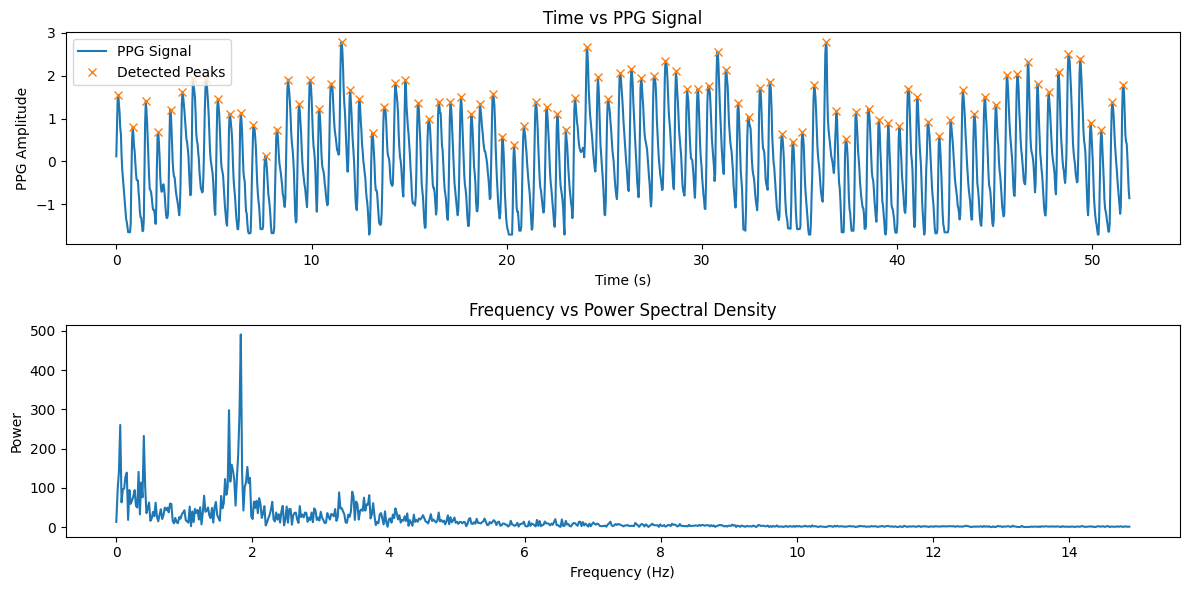

In [7]:
PPG_Signal = data['wave']
time = np.arange(PPG_Signal.size) / fps  # 30FPS로 촬영된 데이터, 시간 배열 생성

# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(rfft(PPG_Signal))
freqs = rfftfreq(PPG_Signal.size, 1 / fps)  # 샘플링 레이트는 초당 30프레임

# 신호에서 피크 찾기
peak_indices, _ = find_peaks(PPG_Signal, distance=10)  # 적절한 거리 설정
IBI = np.diff(peak_indices) / fps  # IBI 계산, 초 단위로 변환

# 모든 IBI 값의 평균을 계산
average_IBI = np.mean(IBI)
bpm_avg = 60 / average_IBI  # 분당 박동수 계산

print("rPPG based Average Heart Rate (BPM): ", bpm_avg)
print("Actual Average Heart Rate: ", np.mean(data['hr']))

# 플로팅
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, PPG_Signal, label='PPG Signal')
plt.plot(time[peak_indices], PPG_Signal[peak_indices], "x", label='Detected Peaks')
plt.title('Time vs PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('PPG Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freqs, psd)
plt.title('Frequency vs Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

In [8]:
# 미분을 계산하기 위한 함수 정의
def derivative(signal):
    # 중앙 차분을 사용하여 미분 계산
    return np.gradient(signal)

In [9]:
# 이 함수는 npz 파일에서 비디오 데이터를 로드하고, 그린 채널의 변화량을 계산하여 신호로 변환하는 데 사용됩니다.
def extract_green_channel_signal(npz_data):
    video_data = npz_data['video']  # (frame_number, height, width, channels)
    green_channel = video_data[:, :, :, 1]  # 그린 채널 추출

    # 각 프레임에 대한 그린 채널의 평균값 계산
    green_channel_mean = green_channel.mean(axis=(1, 2))
    smoothed_wave = gaussian_filter(green_channel_mean, sigma=2)
    diff_smoothed_wave = derivative(smoothed_wave)

    return diff_smoothed_wave

In [21]:
def calculate_hr(npz_data, fps=fps, window_size=150, step_size=30):
    """심박수 계산 및 시간 배열 반환"""
    PPG_Signal = extract_green_channel_signal(npz_data)
    hr_real = npz_data['hr']  # 실제 심박수 데이터
    bpm_per_frame = []
    times = []

    for start in range(0, len(PPG_Signal) - window_size, step_size):
        end = start + window_size
        segment = PPG_Signal[start:end]
        peaks, _ = find_peaks(segment, distance=fps // 2)

        if len(peaks) > 1:
            ibi = np.diff(peaks) / fps
            bpm = 60 / np.mean(ibi) if len(ibi) > 0 else np.nan
        else:
            bpm = np.nan

        bpm_per_frame.append(bpm)
        times.append((start + end) / 2 / fps)

     # hr_real을 times에 맞춰서 조정
    hr_real_adjusted = [hr_real[int(time * fps)] for time in times if int(time * fps) < len(hr_real)]

    return times, bpm_per_frame, hr_real_adjusted
def plot_hr(times, bpm_per_frame, hr_real):
    """심박수 데이터 플롯 및 평균 값 출력"""
    # hr_real에서 10 이하인 값을 NaN으로 설정
    hr_real_filtered = np.array(hr_real)
    hr_real_filtered[hr_real_filtered <= 10] = np.nan

    plt.figure(figsize=(20, 5))
    plt.plot(times, bpm_per_frame, label='Estimated Heart Rate', color='blue', alpha=0.6)
    # plt.plot(np.arange(len(hr_real_filtered)) / fps, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.plot(times, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.title('Estimated vs Actual Heart Rate Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.show()

    # 계산된 BPM과 실제 HR의 평균 계산
    # NaN 값을 무시하고 평균 계산
    # 계산된 BPM과 실제 HR의 평균 및 오류 메트릭 계산
    mean_estimated_bpm = np.nanmean(bpm_per_frame)
    mean_actual_hr = np.nanmean(hr_real_filtered)
    # mse = mean_squared_error([mean_actual_hr], [mean_estimated_bpm])
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error([mean_actual_hr], [mean_estimated_bpm])
    mae, rmse = calculate_errors(bpm_per_frame, hr_real_filtered)

    # 결과 출력
    print(f"Average Estimated Heart Rate: {mean_estimated_bpm:.2f}")
    print(f"Average Actual Heart Rate: {mean_actual_hr:.2f}")
    print(f"MAE: {mae:.2f}")
    # print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print("---------------------------------------------------------------------------")

    return rmse, mae, mean_estimated_bpm, mean_actual_hr

def calculate_errors(bpm_per_frame, hr_real_filtered):
    # NaN이 아닌 인덱스를 찾습니다.
    valid_indices = ~np.isnan(bpm_per_frame) & ~np.isnan(hr_real_filtered)

    # 유효한 인덱스만 사용하여 데이터를 필터링합니다.
    filtered_bpm = np.array(bpm_per_frame)[valid_indices]
    filtered_hr_real = np.array(hr_real_filtered)[valid_indices]

    # MAE와 RMSE를 계산합니다.
    mae = mean_absolute_error(filtered_hr_real, filtered_bpm)
    rmse = np.sqrt(mean_squared_error(filtered_hr_real, filtered_bpm))

    return mae, rmse

def process_npz_files(directory):
    """디렉토리 내의 모든 NPZ 파일 처리"""
    mse_list, rmse_list, mae_list = [], [], []
    subject_list = []
    mean_estimated_hrs = []
    mean_actural_hrs = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.npz'):
            file_path = os.path.join(directory, file_name)
            print(f"Processing {file_path}...")
            npz_data = np.load(file_path)
            times, bpm_per_frame, hr_real = calculate_hr(npz_data)
            rmse, mae, mean_estimated_hr, mean_actural_hr = plot_hr(times, bpm_per_frame, hr_real)
            mean_estimated_hrs.append(mean_estimated_hr)
            mean_actural_hrs.append(mean_actural_hr)
            # mse_list.append(mse)
            rmse_list.append(rmse)
            mae_list.append(mae)
            subject_list.append(file_name.replace('.npz', ''))

    return rmse_list, mae_list, subject_list, mean_estimated_hrs, mean_actural_hrs

Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz...


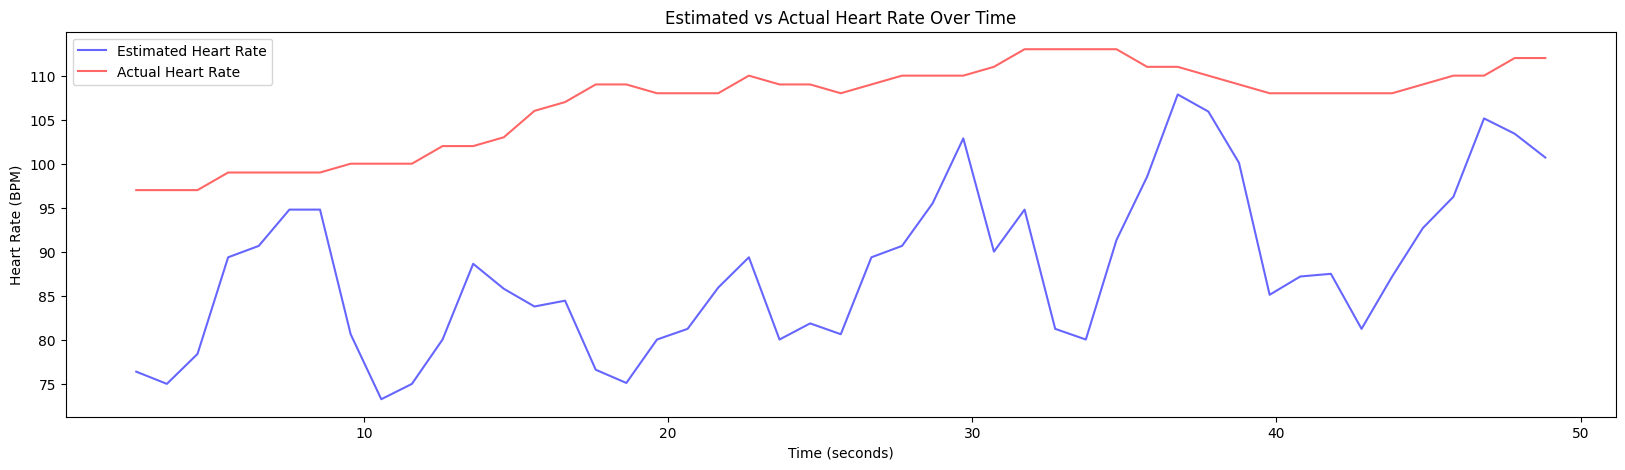

Average Estimated Heart Rate: 88.01
Average Actual Heart Rate: 106.83
MAE: 18.82
RMSE: 20.57
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject10.npz...


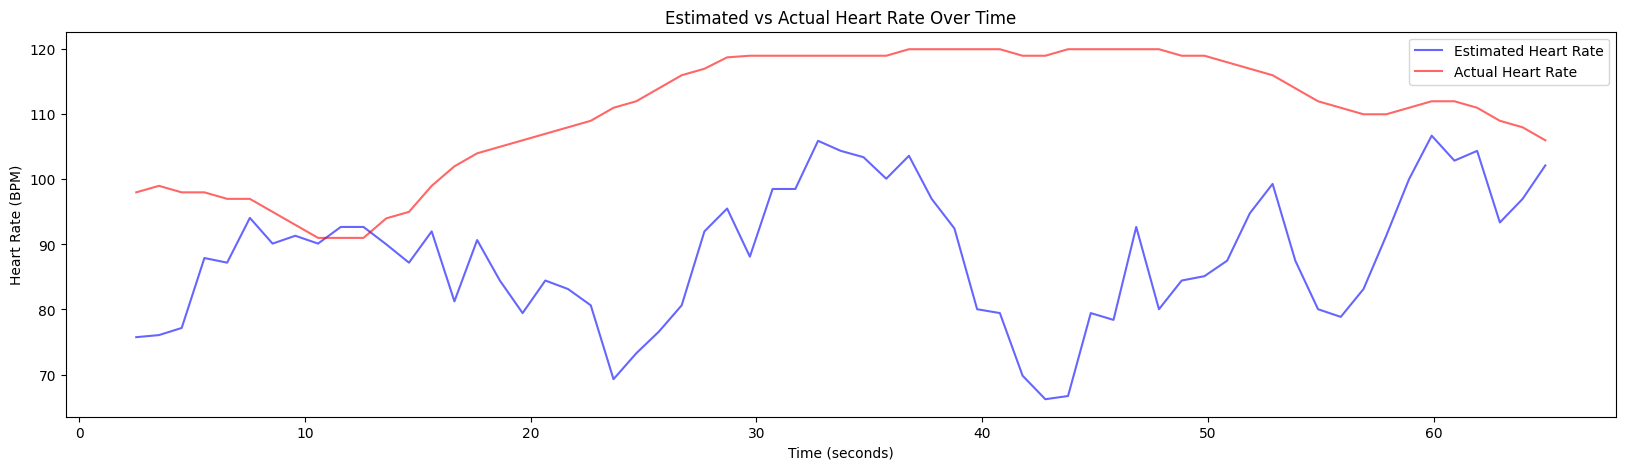

Average Estimated Heart Rate: 88.23
Average Actual Heart Rate: 110.35
MAE: 22.22
RMSE: 25.95
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject11.npz...


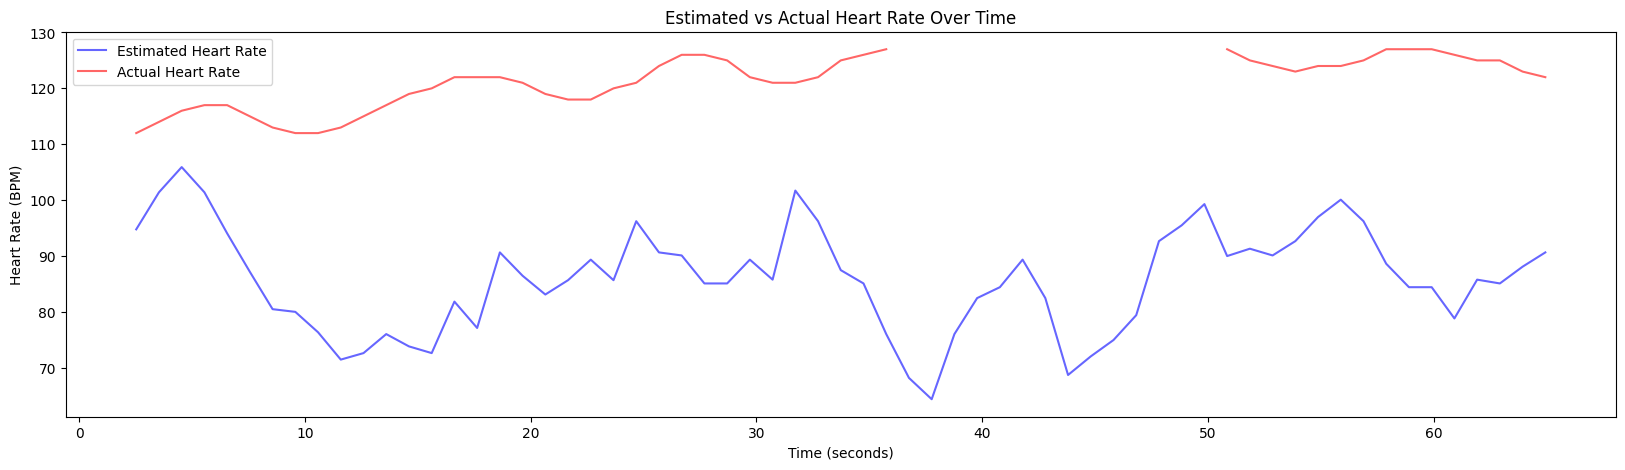

Average Estimated Heart Rate: 85.90
Average Actual Heart Rate: 121.10
MAE: 33.73
RMSE: 34.89
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject12.npz...


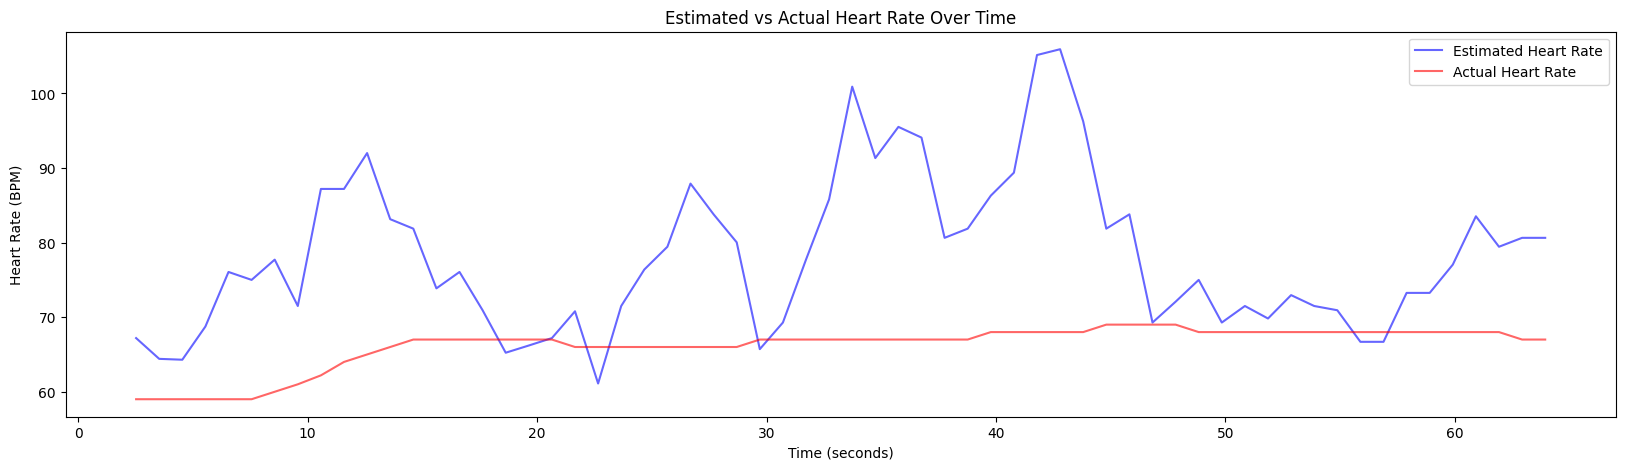

Average Estimated Heart Rate: 78.09
Average Actual Heart Rate: 66.15
MAE: 12.31
RMSE: 15.59
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject13.npz...


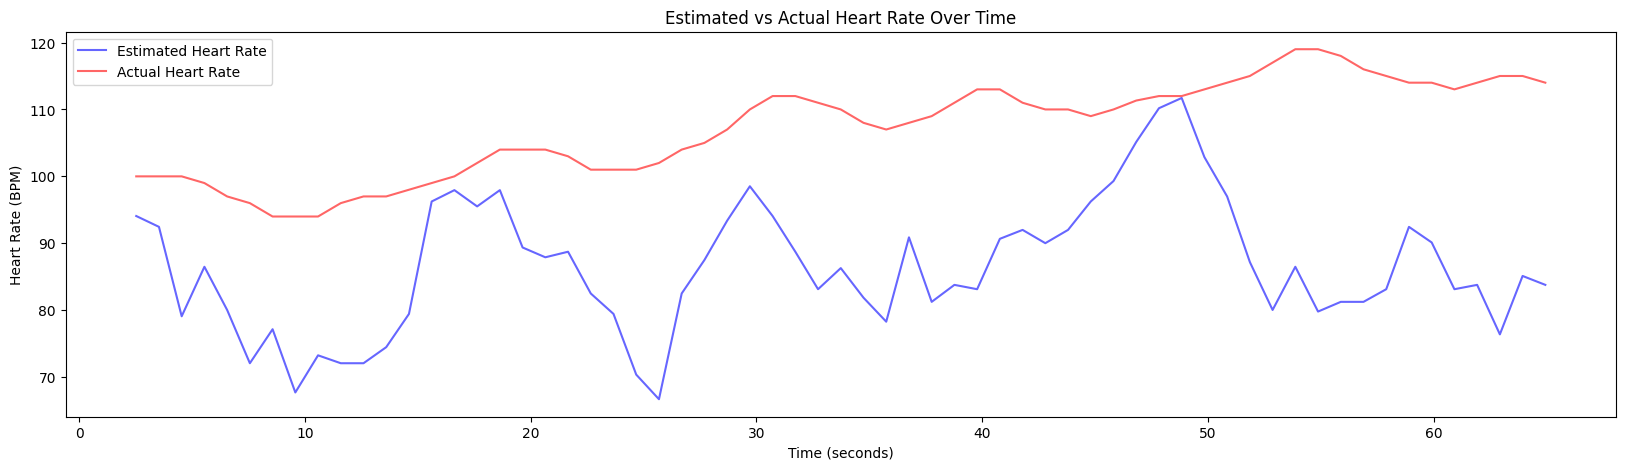

Average Estimated Heart Rate: 86.47
Average Actual Heart Rate: 107.20
MAE: 20.73
RMSE: 22.88
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject14.npz...


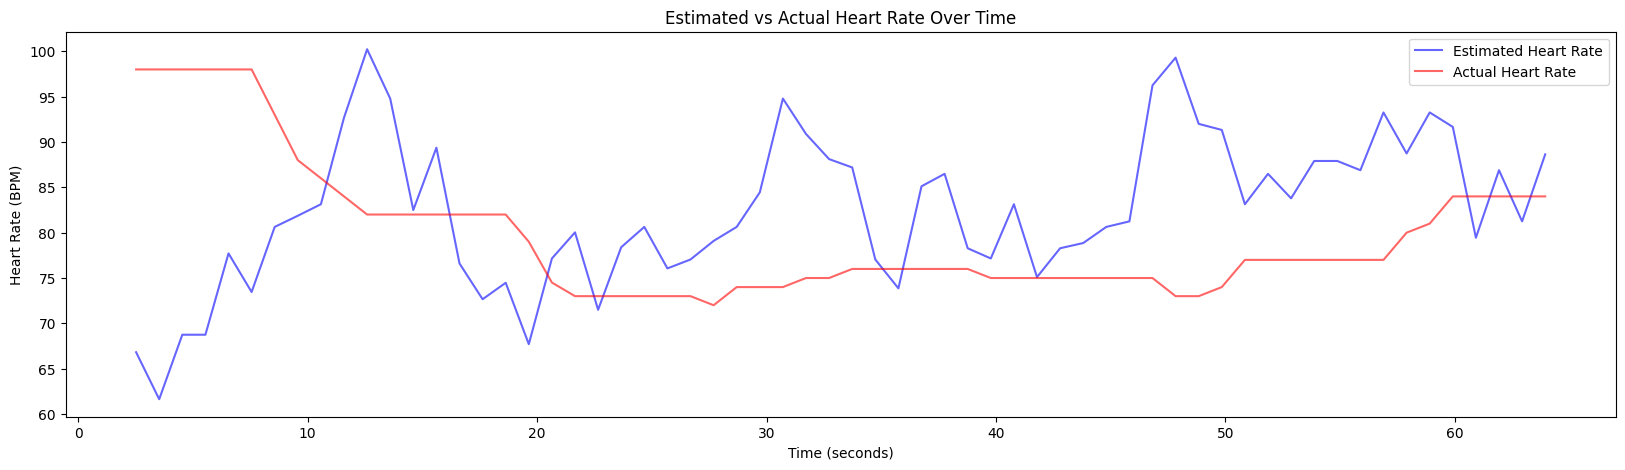

Average Estimated Heart Rate: 82.47
Average Actual Heart Rate: 79.75
MAE: 10.36
RMSE: 13.19
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject15.npz...


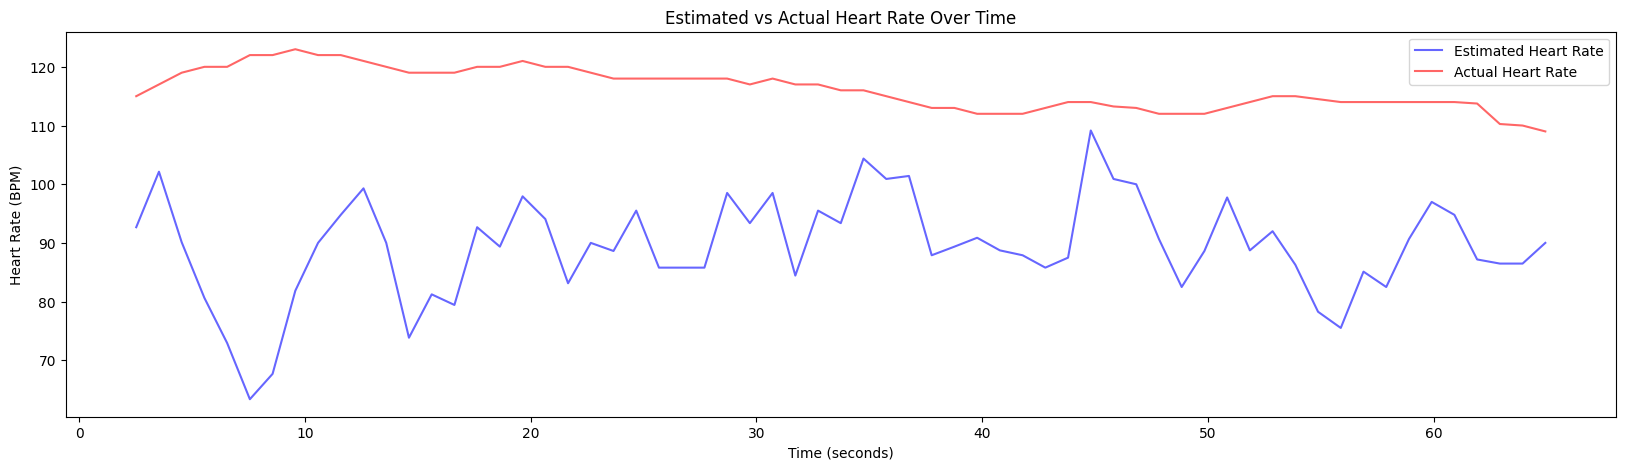

Average Estimated Heart Rate: 89.33
Average Actual Heart Rate: 116.22
MAE: 26.88
RMSE: 28.62
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject16.npz...


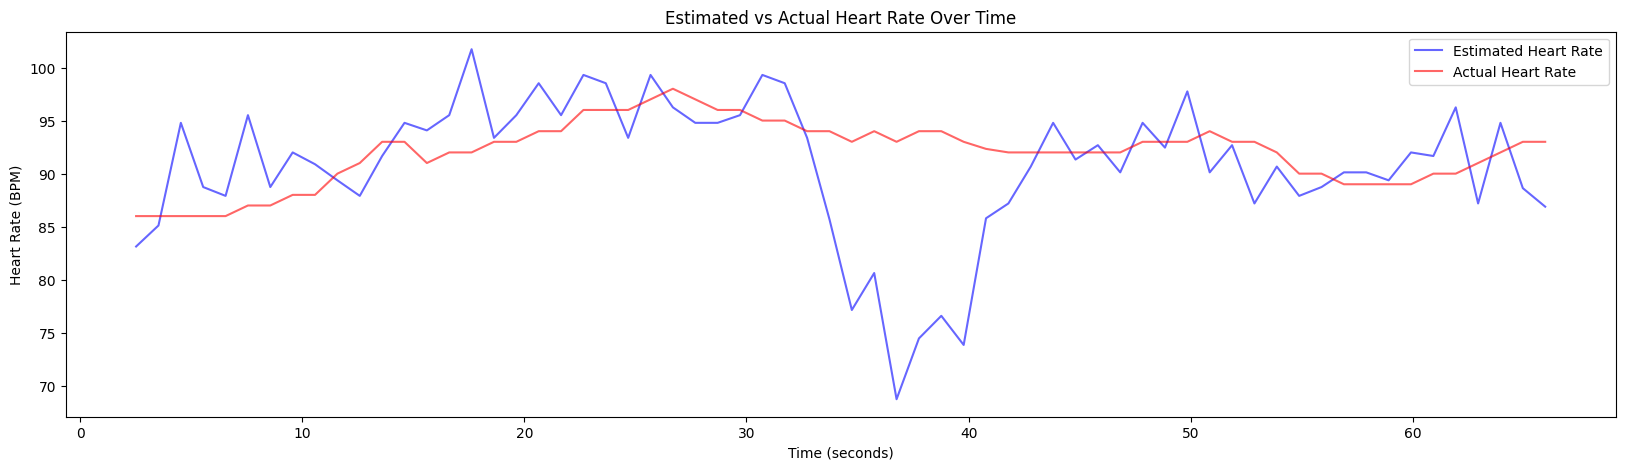

Average Estimated Heart Rate: 90.73
Average Actual Heart Rate: 91.99
MAE: 4.38
RMSE: 6.68
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject17.npz...


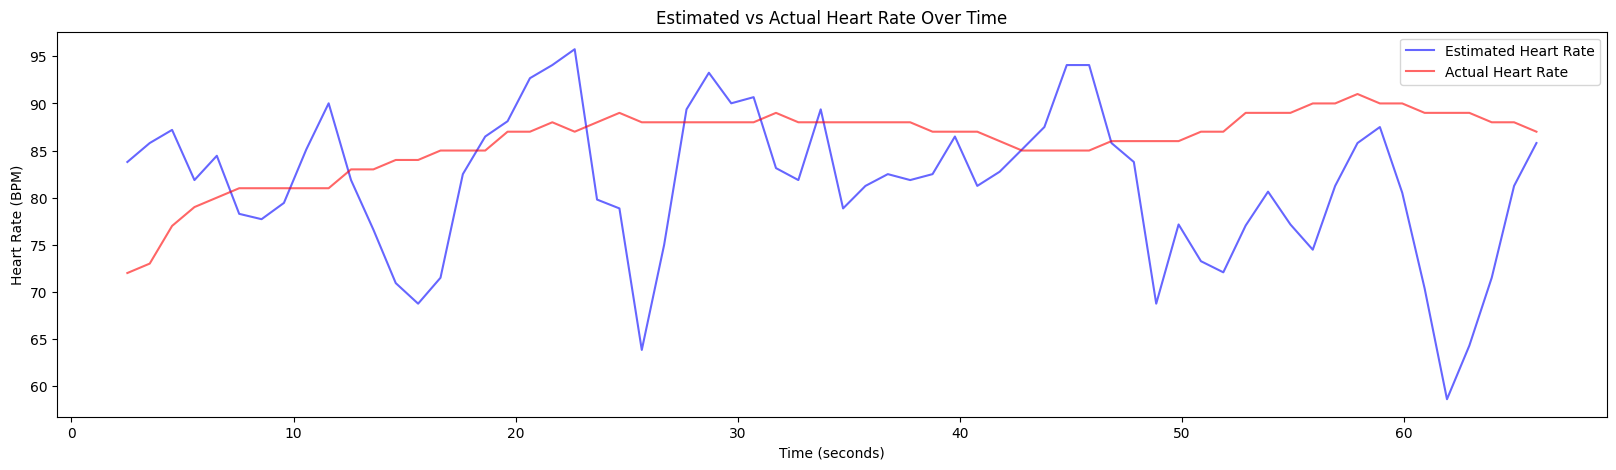

Average Estimated Heart Rate: 81.46
Average Actual Heart Rate: 85.92
MAE: 7.96
RMSE: 10.15
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject18.npz...


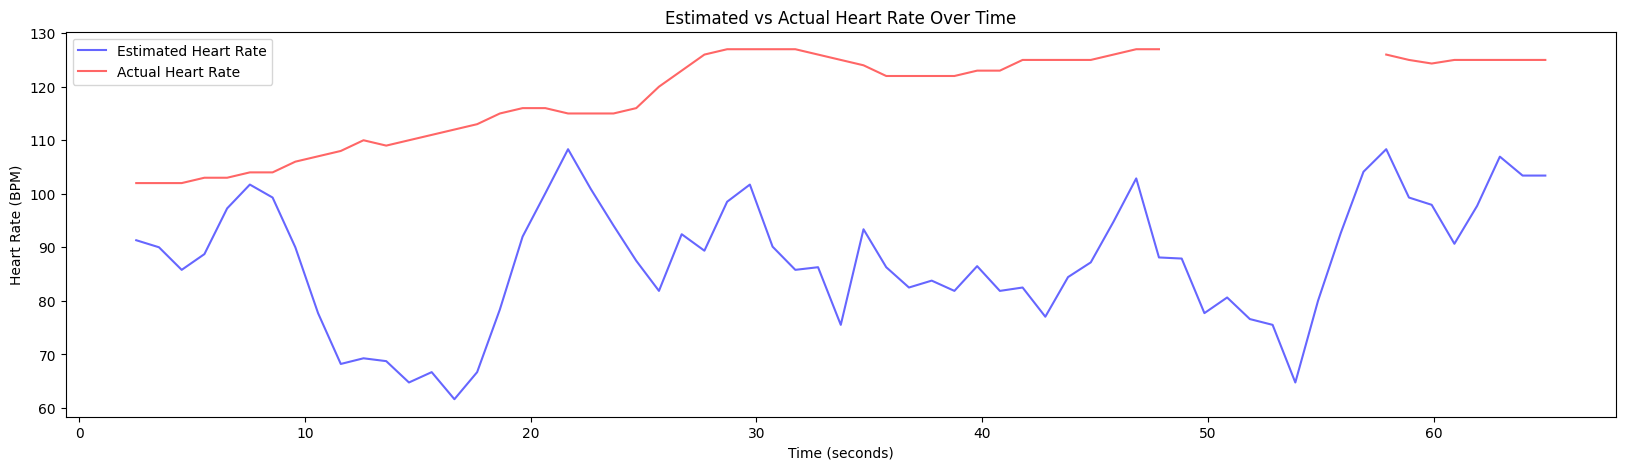

Average Estimated Heart Rate: 87.49
Average Actual Heart Rate: 118.15
MAE: 29.79
RMSE: 32.30
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject20.npz...


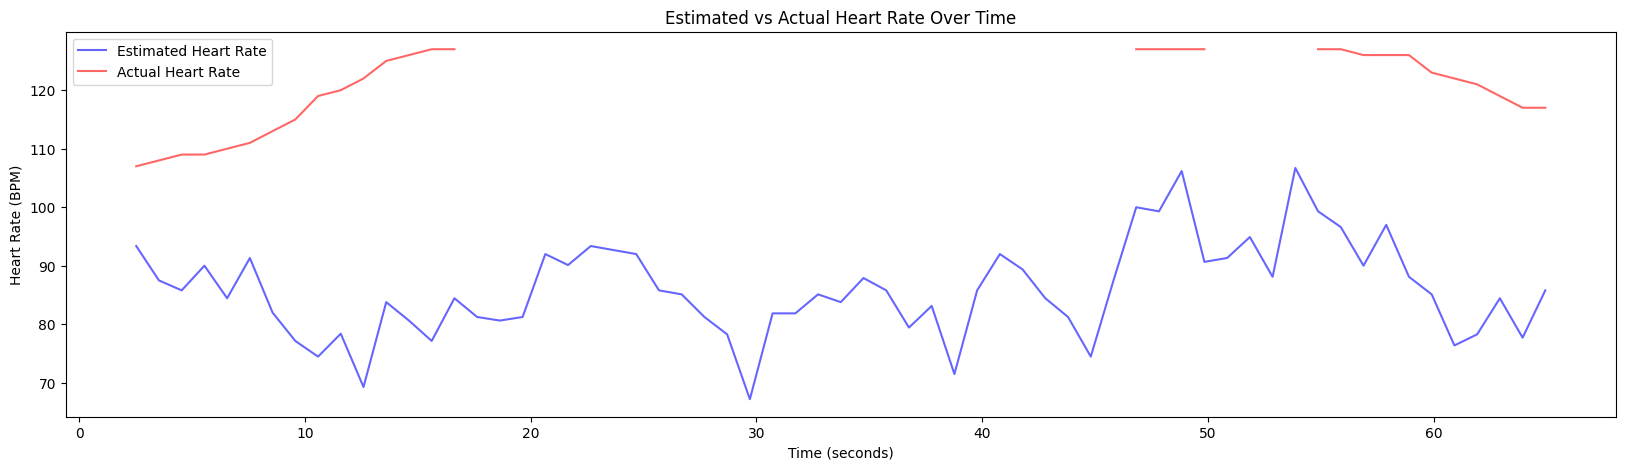

Average Estimated Heart Rate: 85.90
Average Actual Heart Rate: 120.23
MAE: 33.74
RMSE: 35.14
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject22.npz...


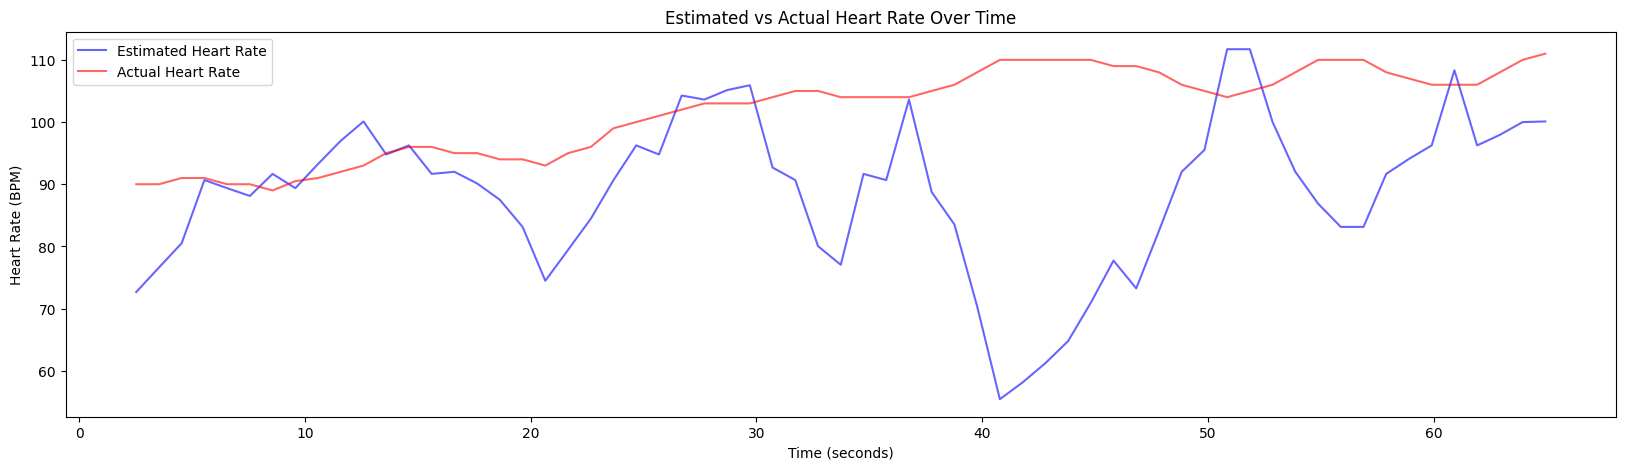

Average Estimated Heart Rate: 88.85
Average Actual Heart Rate: 101.72
MAE: 14.21
RMSE: 19.56
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject23.npz...


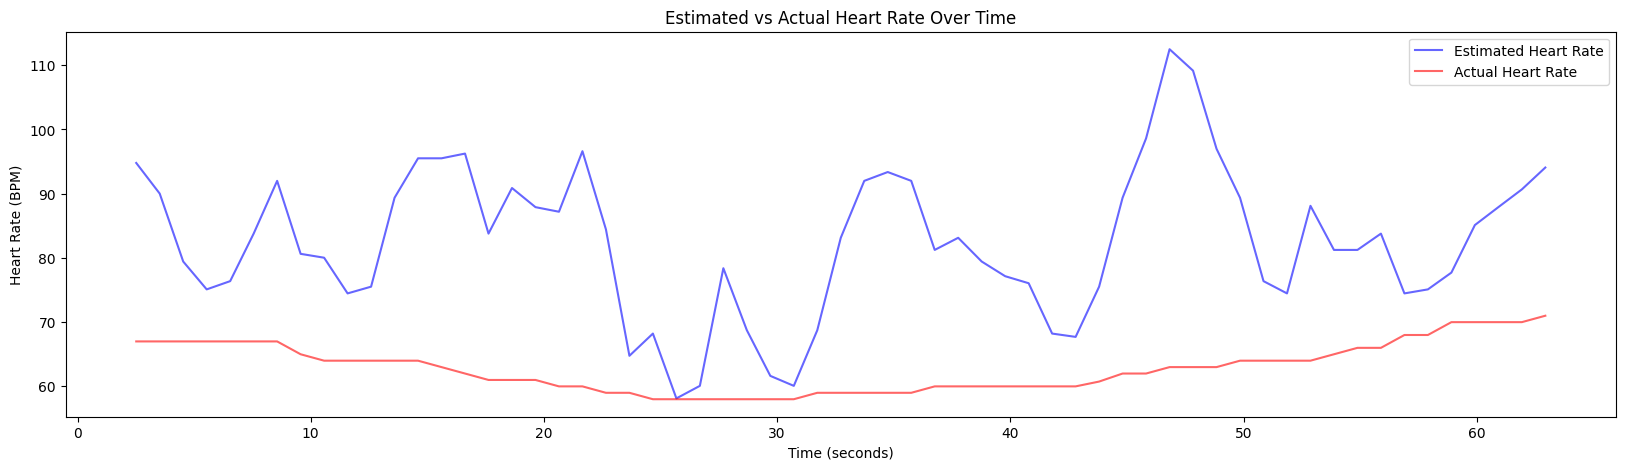

Average Estimated Heart Rate: 82.52
Average Actual Heart Rate: 62.86
MAE: 19.66
RMSE: 22.46
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject24.npz...


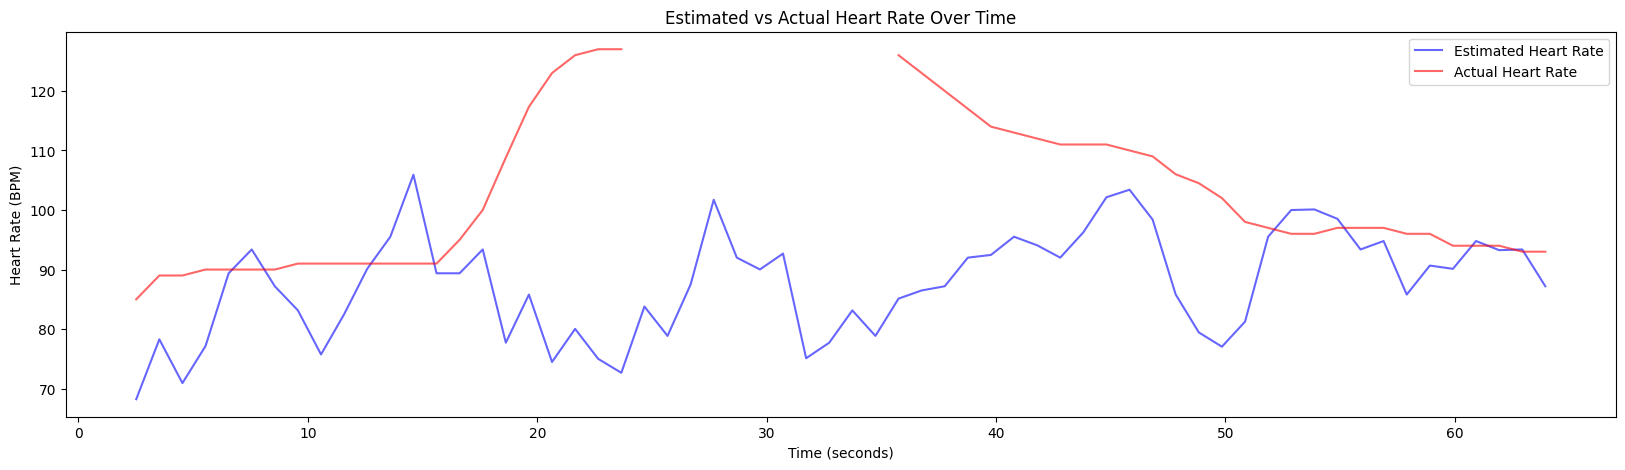

Average Estimated Heart Rate: 87.78
Average Actual Heart Rate: 102.19
MAE: 15.25
RMSE: 20.99
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject25.npz...


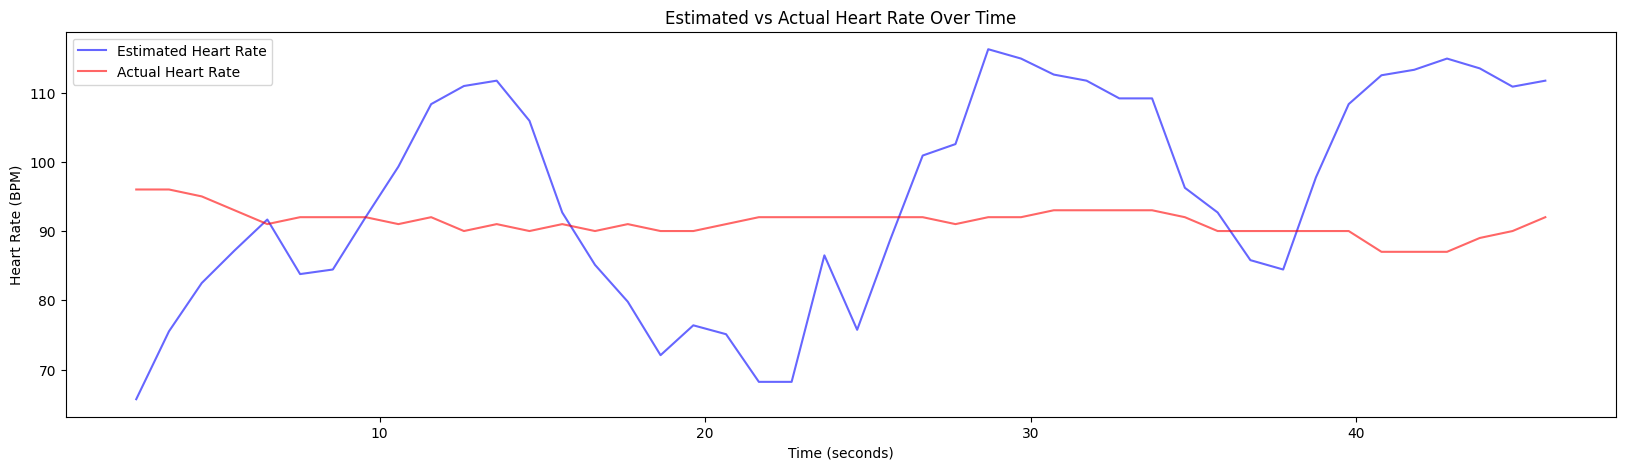

Average Estimated Heart Rate: 95.15
Average Actual Heart Rate: 91.30
MAE: 14.35
RMSE: 16.55
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject26.npz...


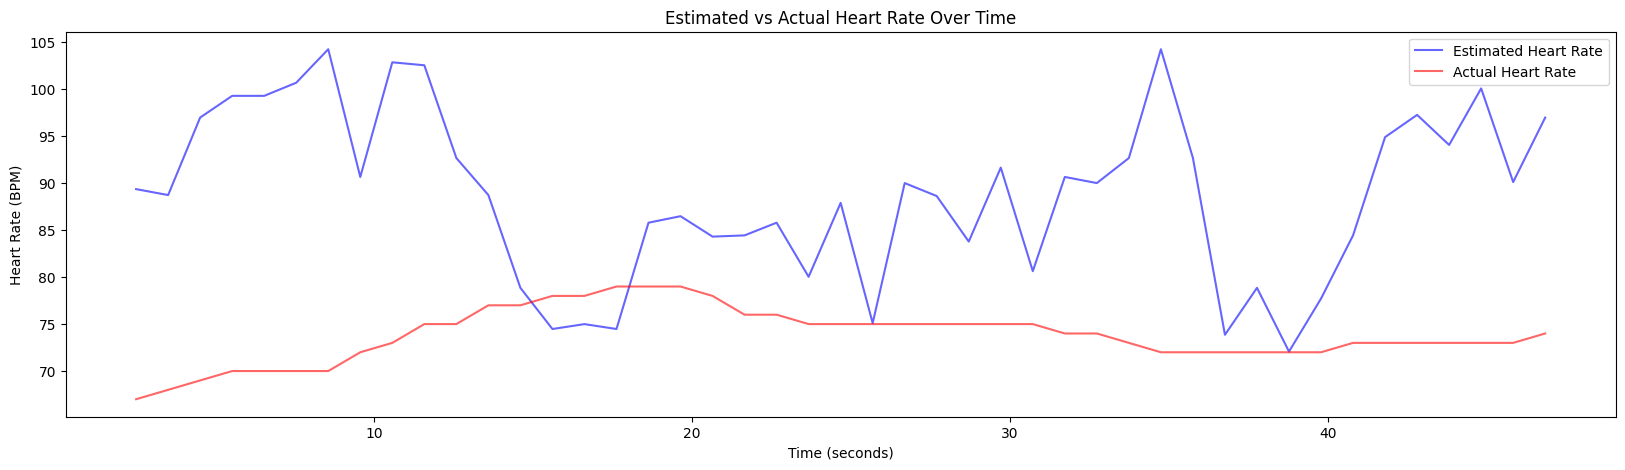

Average Estimated Heart Rate: 88.76
Average Actual Heart Rate: 73.80
MAE: 15.45
RMSE: 18.27
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject27.npz...


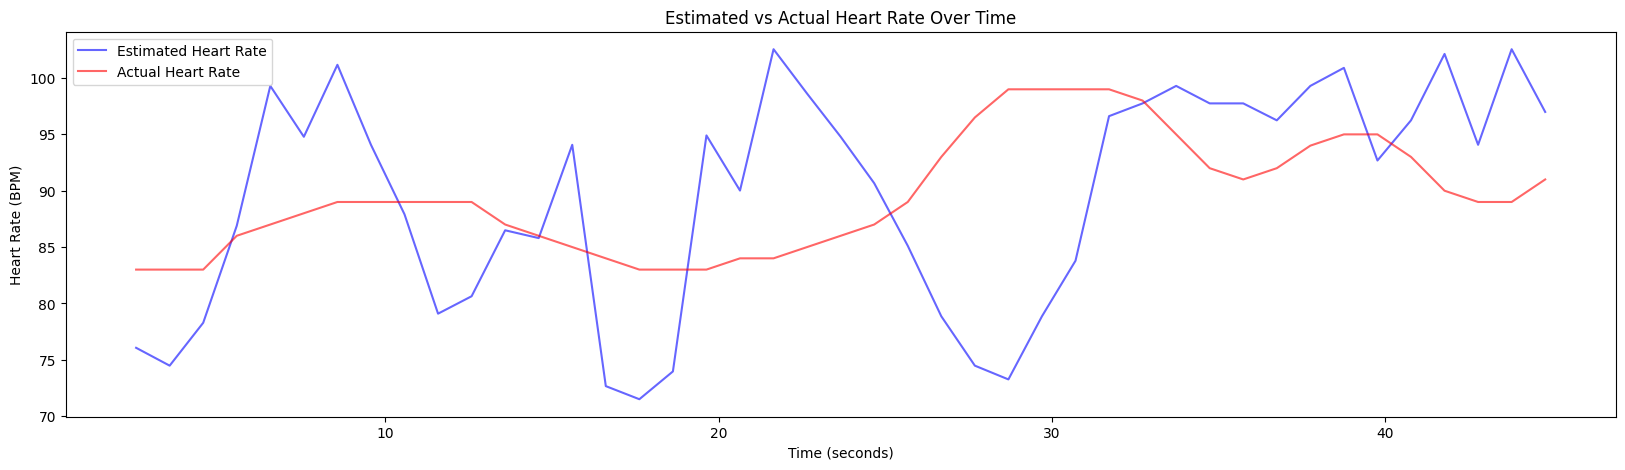

Average Estimated Heart Rate: 89.61
Average Actual Heart Rate: 89.55
MAE: 8.36
RMSE: 10.23
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject3.npz...


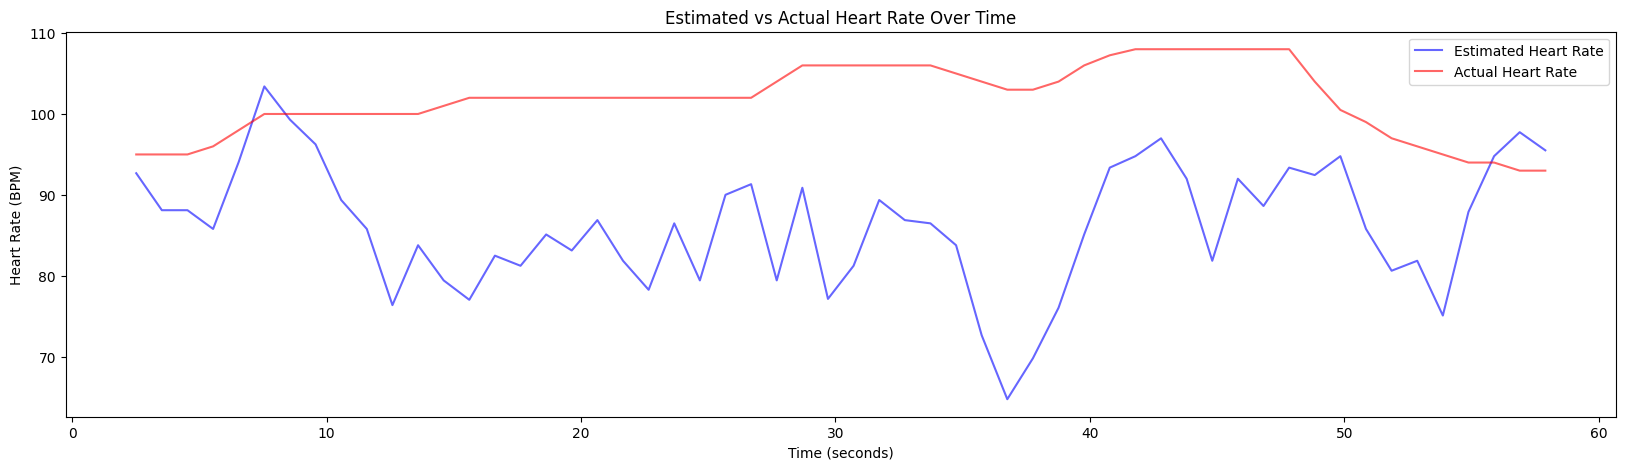

Average Estimated Heart Rate: 86.23
Average Actual Heart Rate: 101.75
MAE: 15.92
RMSE: 18.02
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject30.npz...


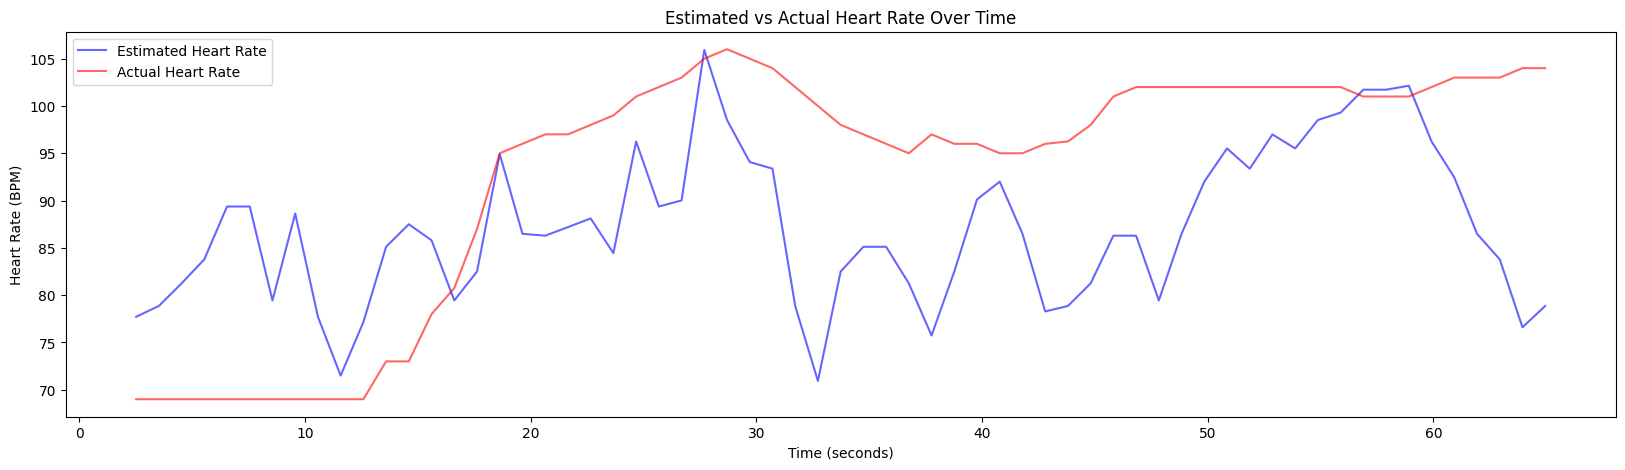

Average Estimated Heart Rate: 87.12
Average Actual Heart Rate: 93.00
MAE: 11.39
RMSE: 13.28
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject31.npz...


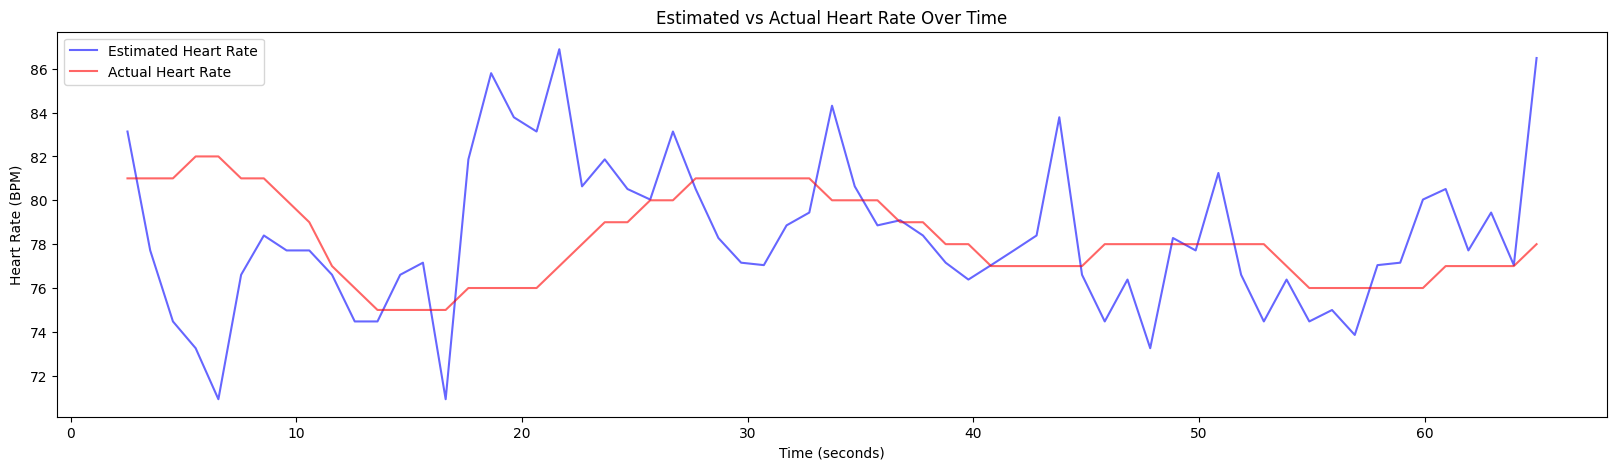

Average Estimated Heart Rate: 78.33
Average Actual Heart Rate: 78.19
MAE: 2.89
RMSE: 3.95
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject32.npz...


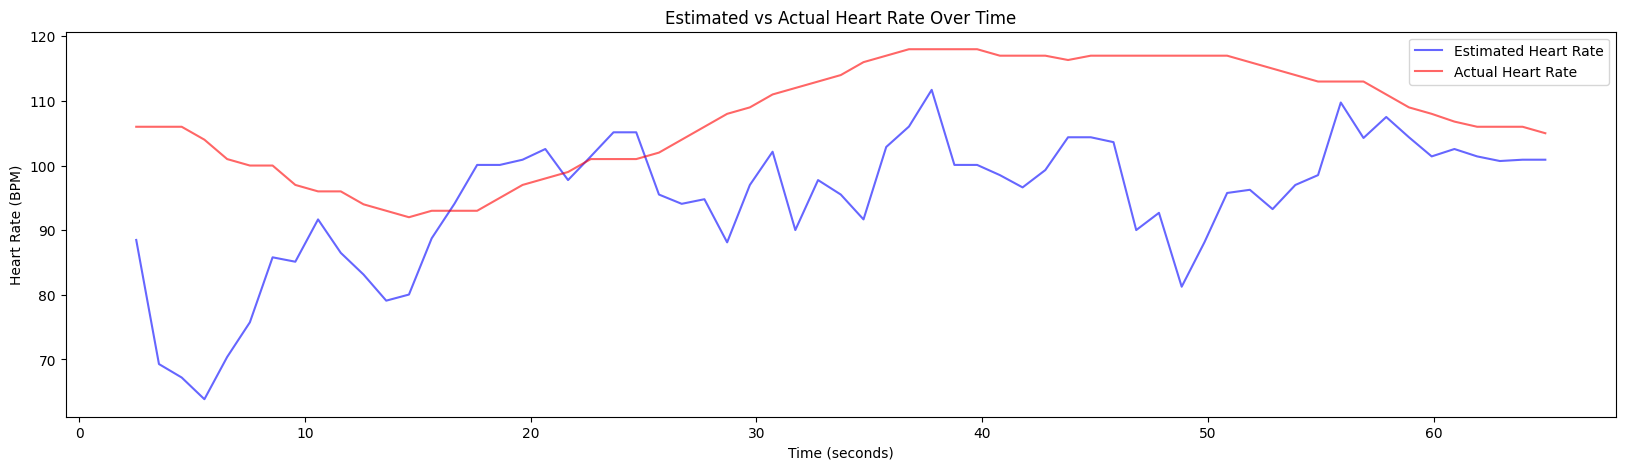

Average Estimated Heart Rate: 94.65
Average Actual Heart Rate: 107.53
MAE: 13.84
RMSE: 16.91
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject33.npz...


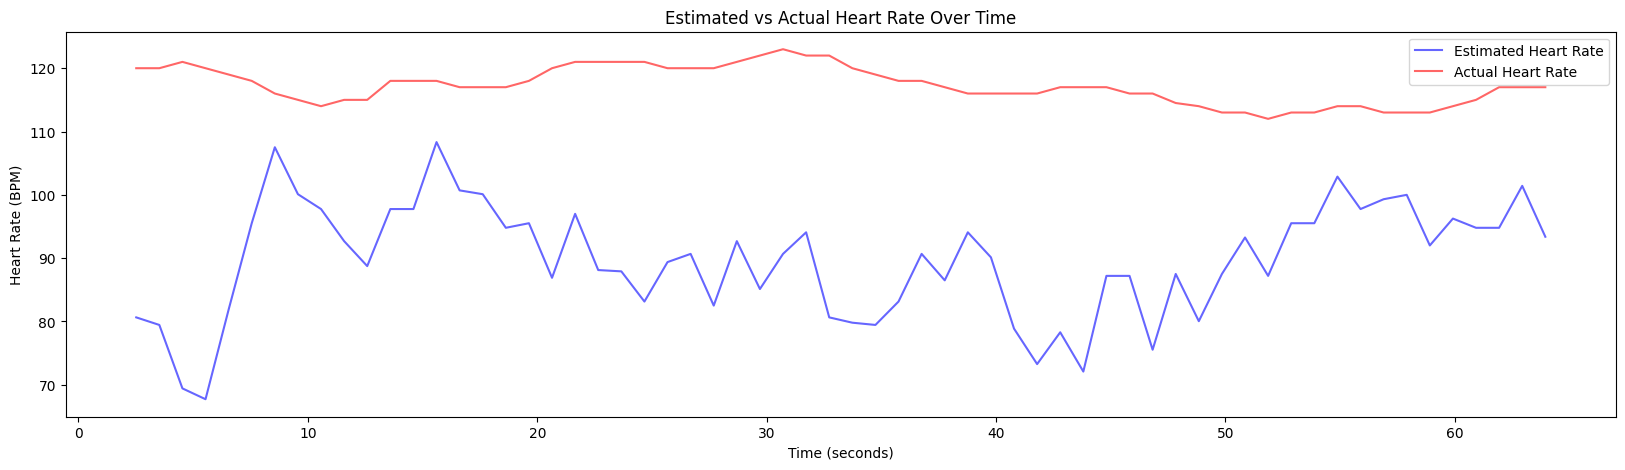

Average Estimated Heart Rate: 89.68
Average Actual Heart Rate: 117.23
MAE: 27.55
RMSE: 29.38
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject34.npz...


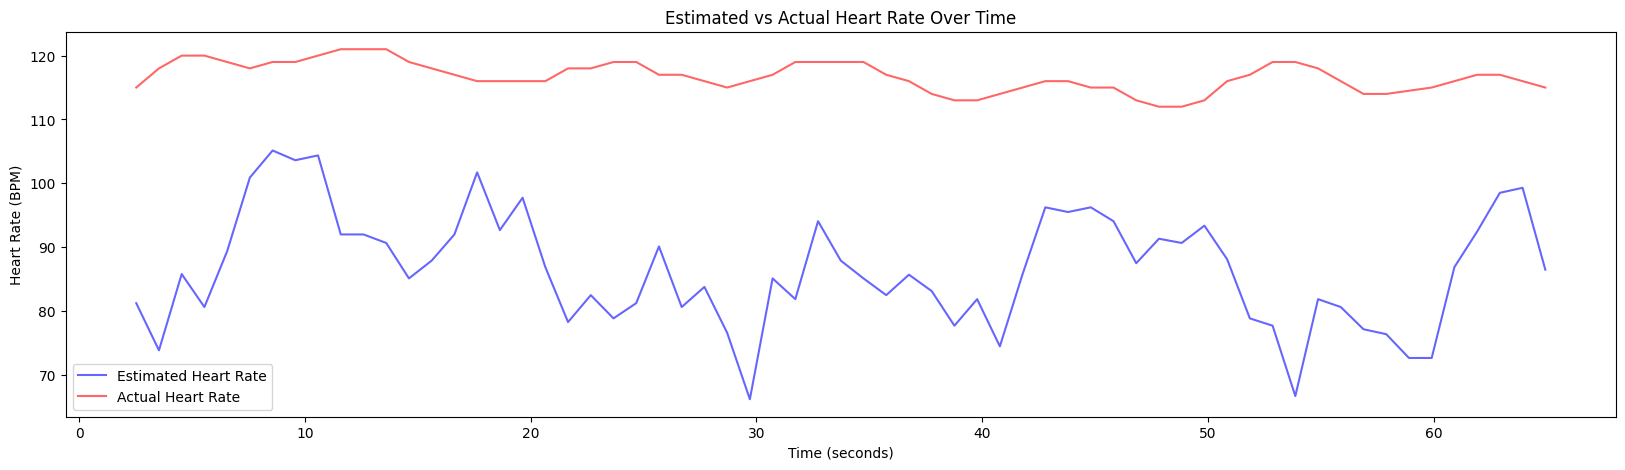

Average Estimated Heart Rate: 86.48
Average Actual Heart Rate: 116.74
MAE: 30.25
RMSE: 31.51
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject35.npz...


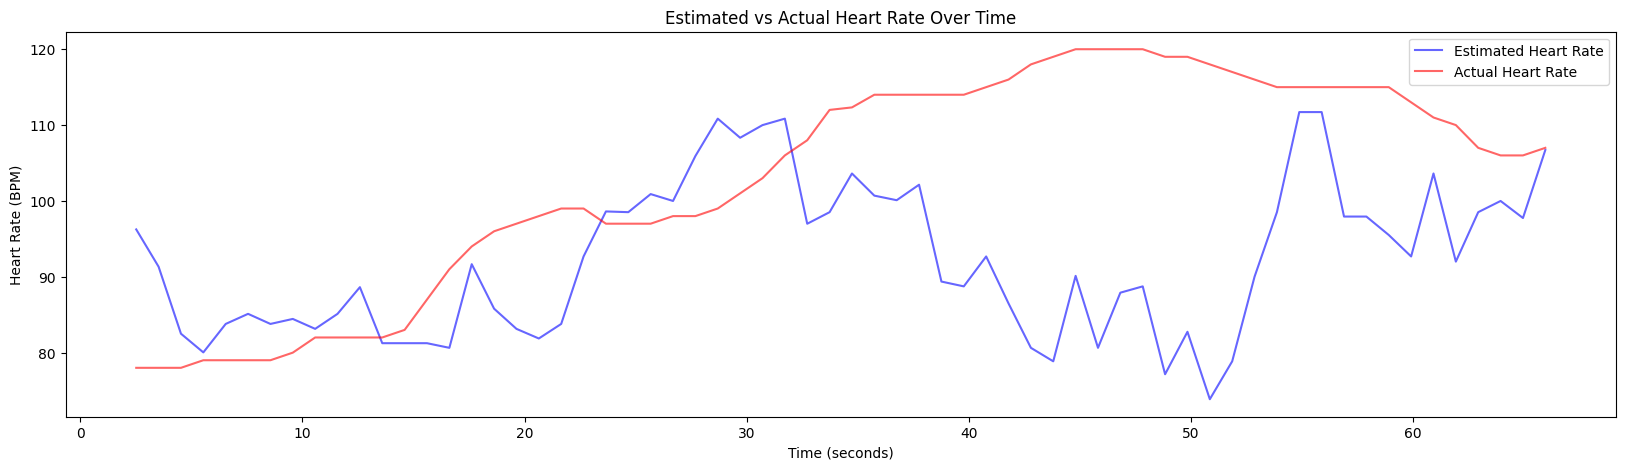

Average Estimated Heart Rate: 92.26
Average Actual Heart Rate: 102.93
MAE: 14.29
RMSE: 18.69
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject36.npz...


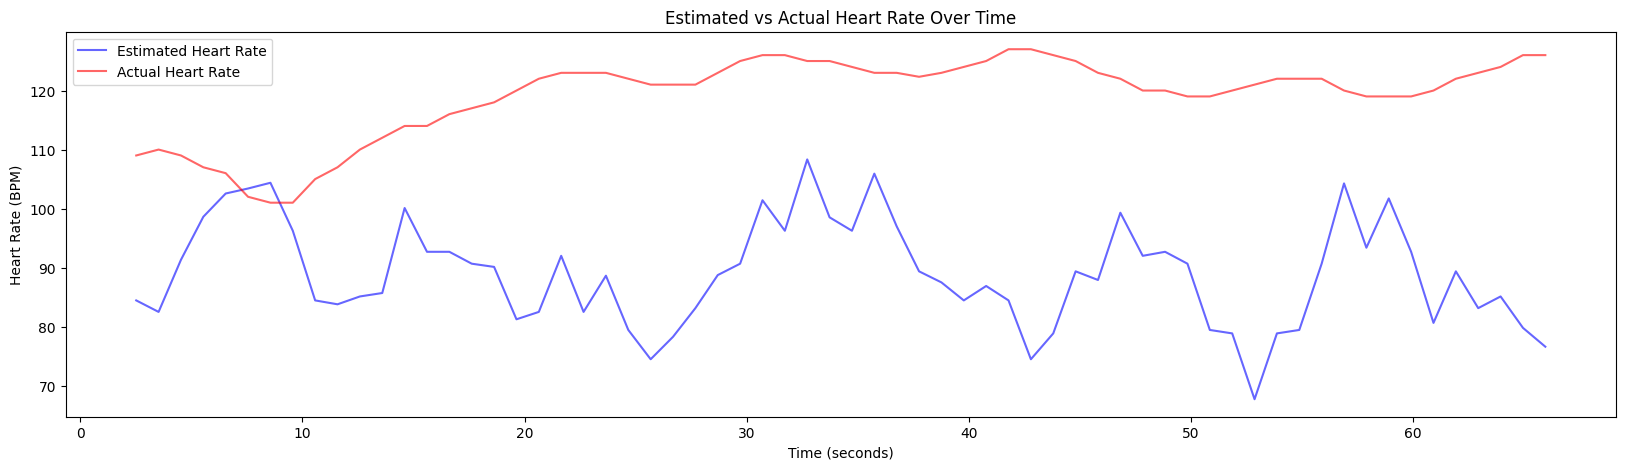

Average Estimated Heart Rate: 88.96
Average Actual Heart Rate: 119.08
MAE: 30.27
RMSE: 32.55
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject37.npz...


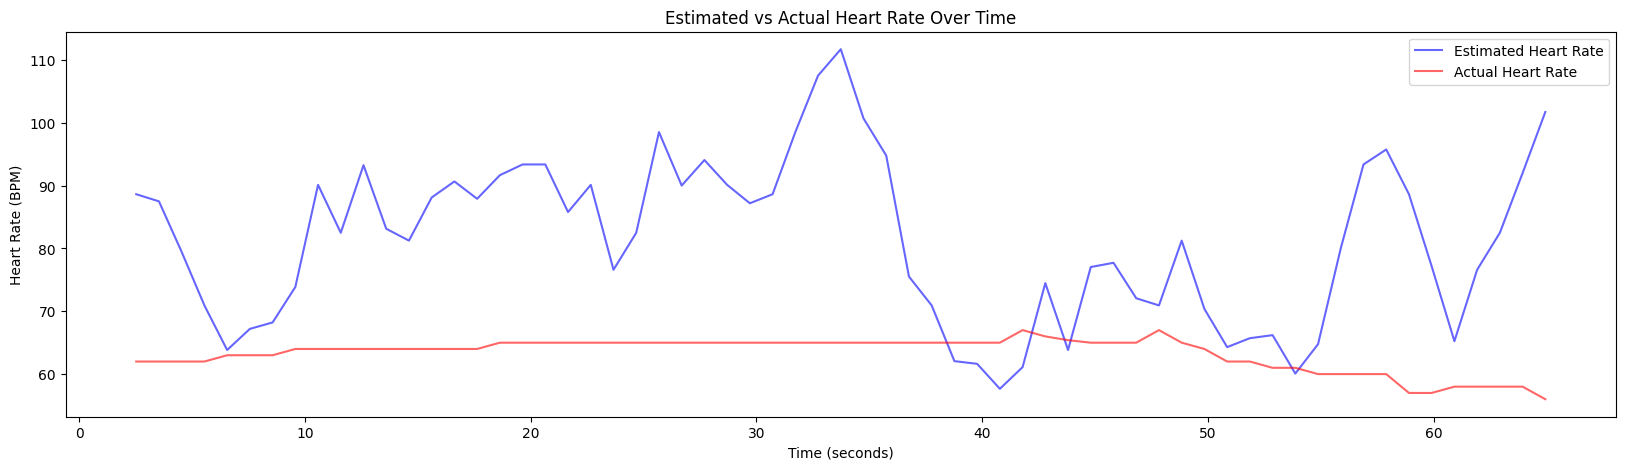

Average Estimated Heart Rate: 81.31
Average Actual Heart Rate: 63.26
MAE: 18.75
RMSE: 22.25
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject38.npz...


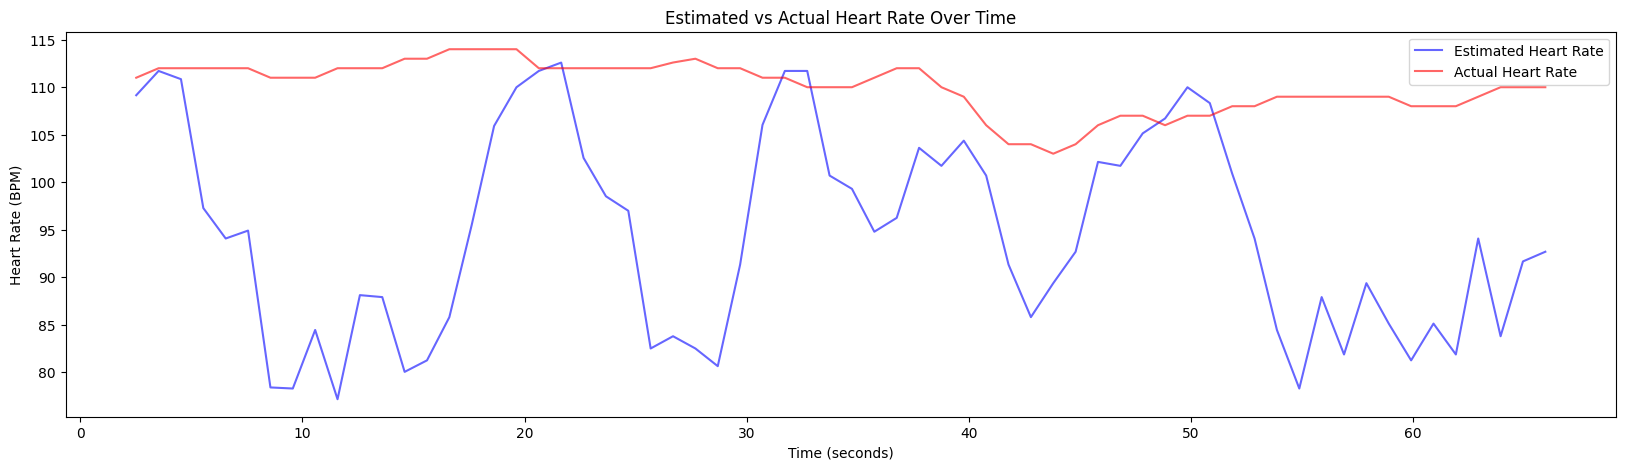

Average Estimated Heart Rate: 94.54
Average Actual Heart Rate: 110.06
MAE: 15.77
RMSE: 18.99
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject39.npz...


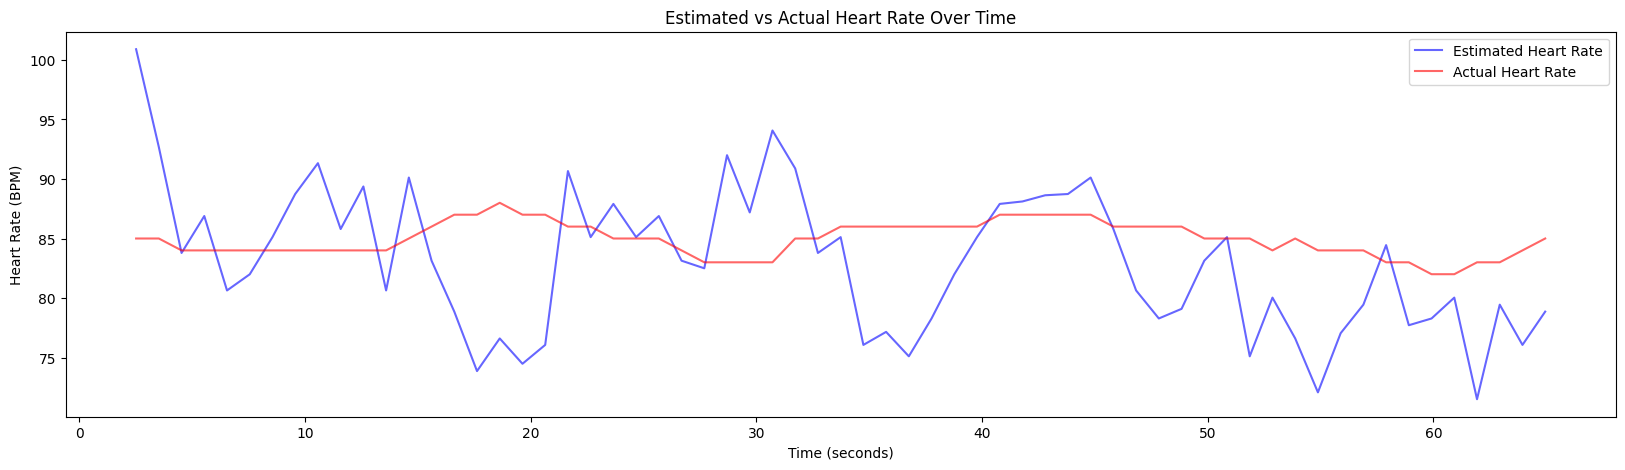

Average Estimated Heart Rate: 83.04
Average Actual Heart Rate: 84.95
MAE: 5.15
RMSE: 6.48
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject4.npz...


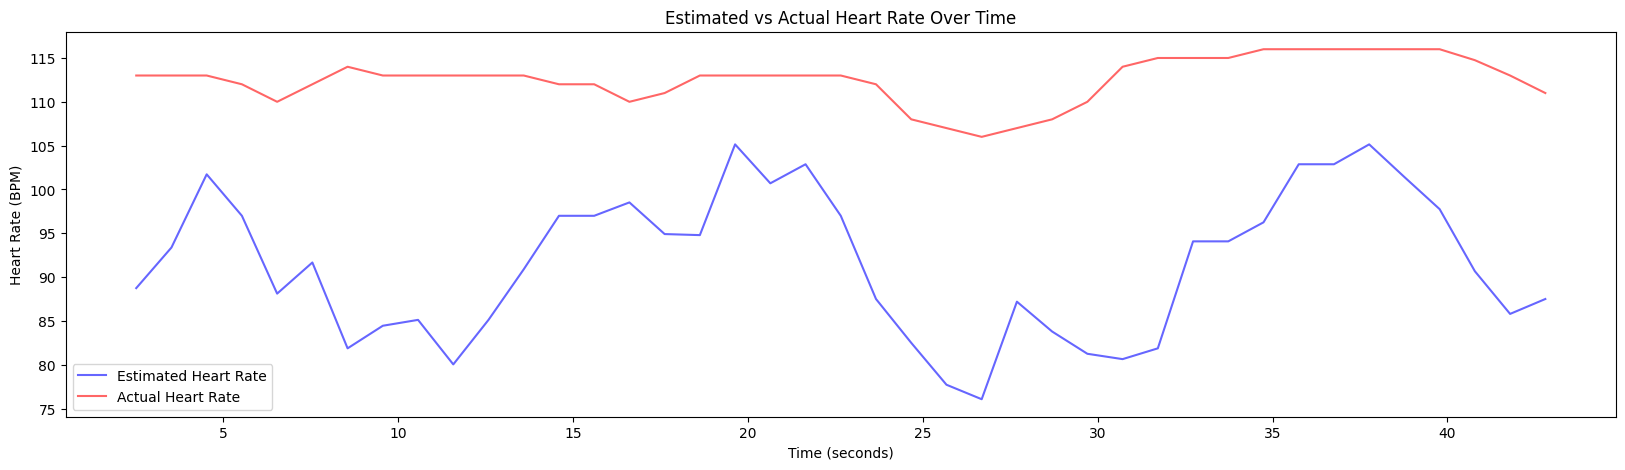

Average Estimated Heart Rate: 91.53
Average Actual Heart Rate: 112.53
MAE: 21.00
RMSE: 22.15
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject40.npz...


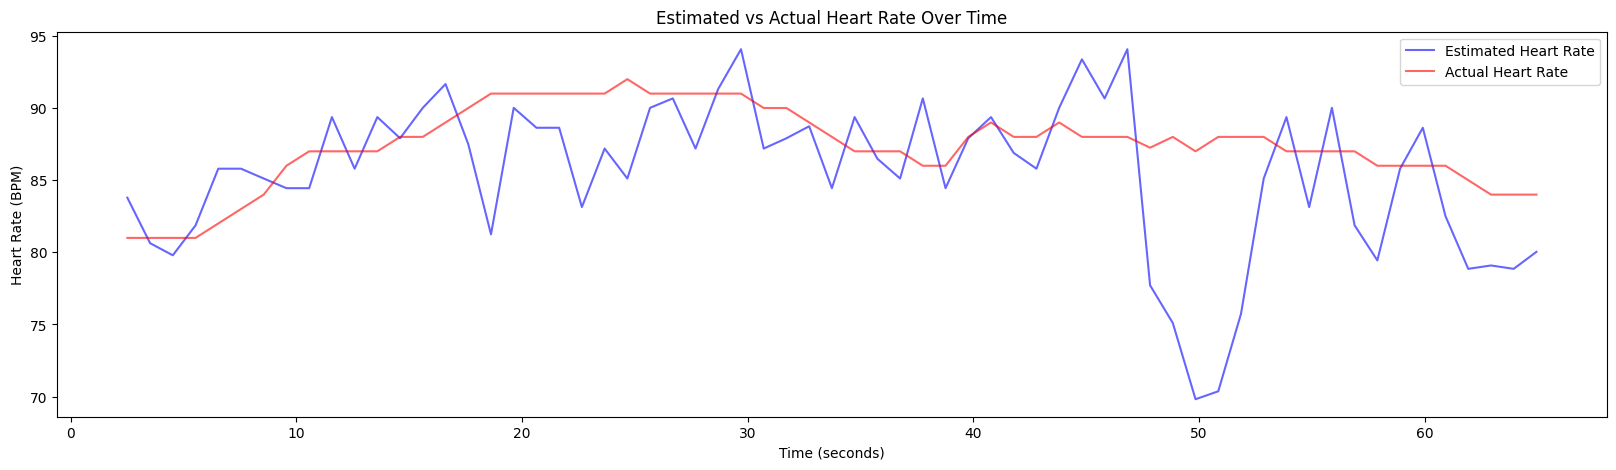

Average Estimated Heart Rate: 85.47
Average Actual Heart Rate: 87.40
MAE: 3.67
RMSE: 5.21
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject41.npz...


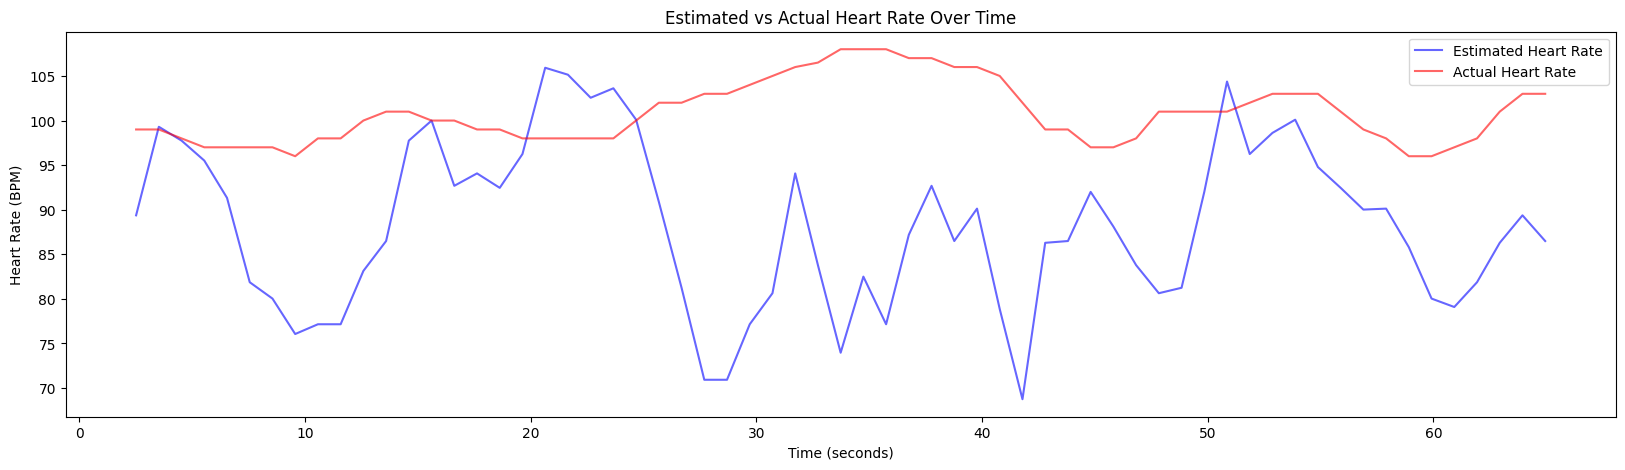

Average Estimated Heart Rate: 88.24
Average Actual Heart Rate: 100.82
MAE: 13.50
RMSE: 16.21
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject42.npz...


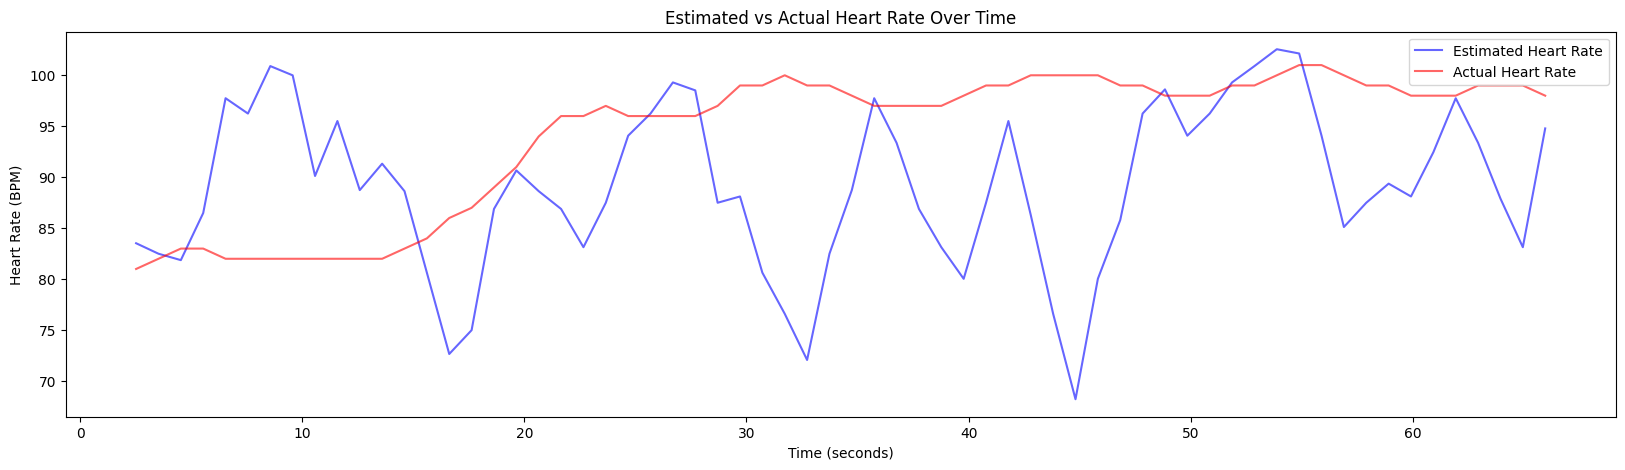

Average Estimated Heart Rate: 89.14
Average Actual Heart Rate: 94.16
MAE: 9.09
RMSE: 11.62
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject43.npz...


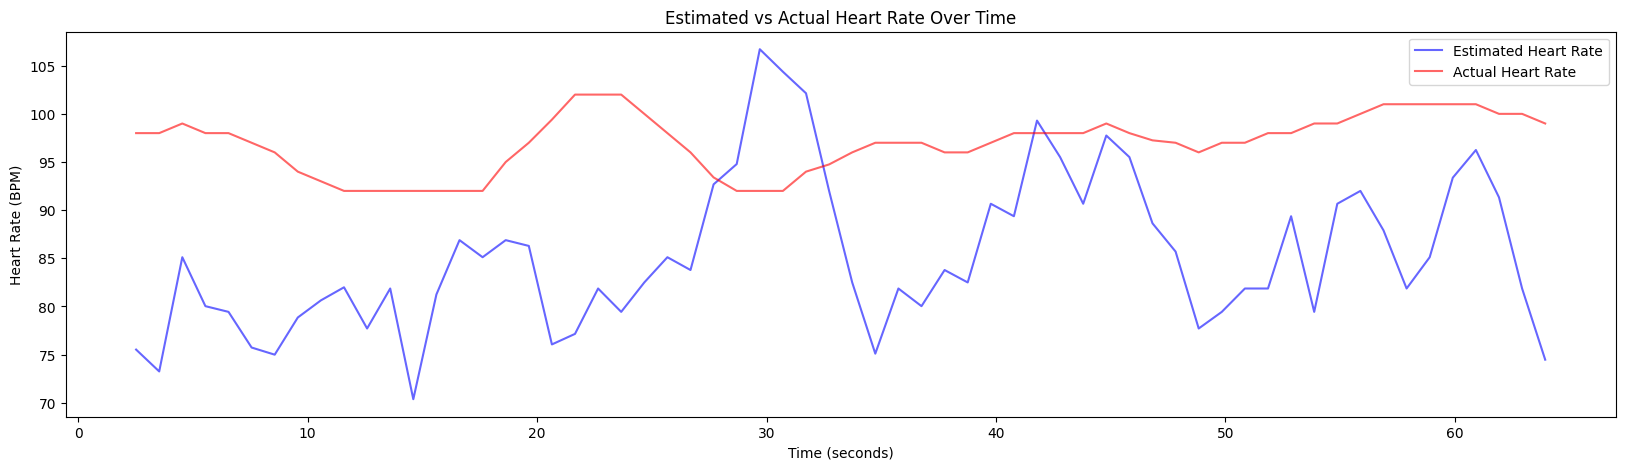

Average Estimated Heart Rate: 85.23
Average Actual Heart Rate: 96.96
MAE: 13.01
RMSE: 14.56
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject44.npz...


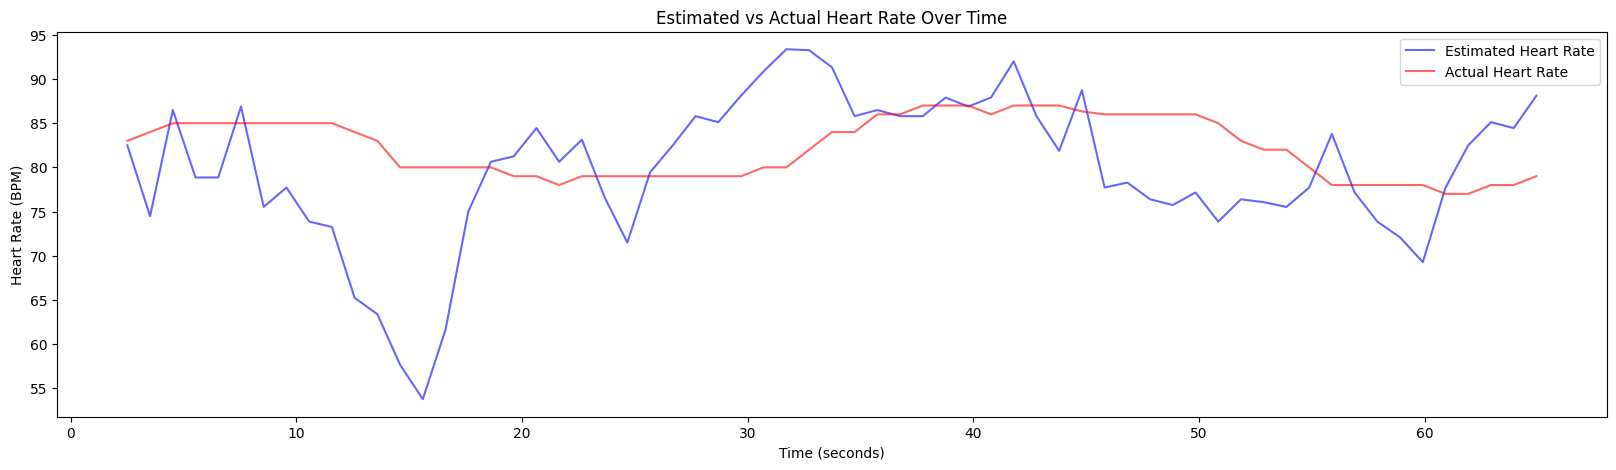

Average Estimated Heart Rate: 79.79
Average Actual Heart Rate: 82.21
MAE: 6.69
RMSE: 8.67
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject45.npz...


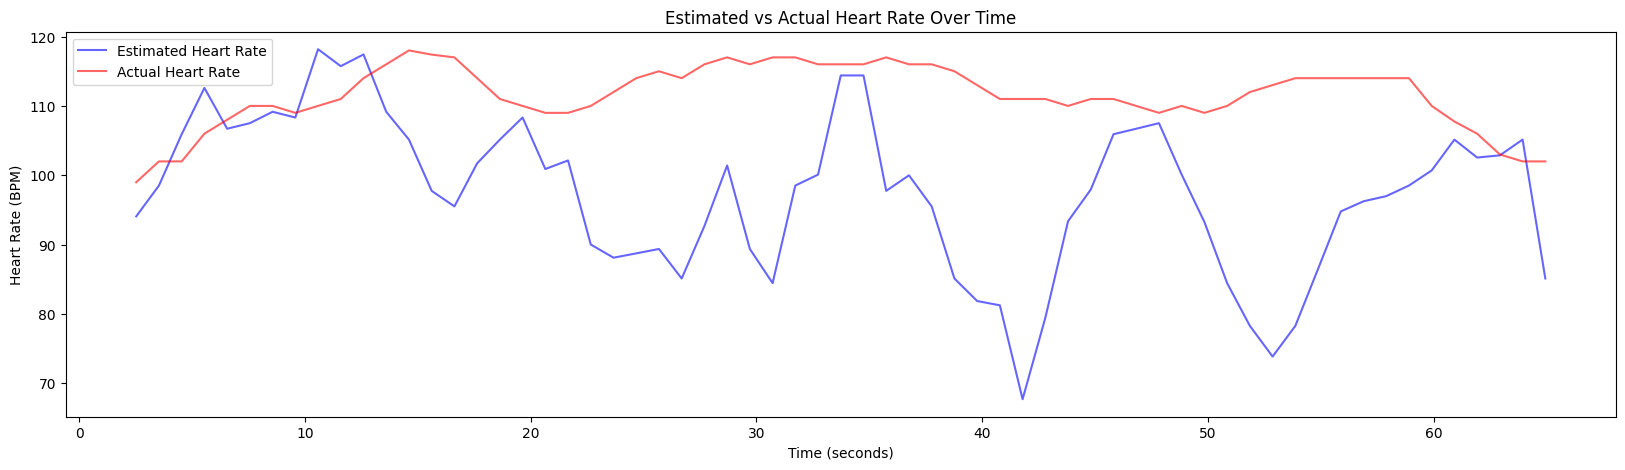

Average Estimated Heart Rate: 97.45
Average Actual Heart Rate: 111.56
MAE: 15.06
RMSE: 18.81
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject46.npz...


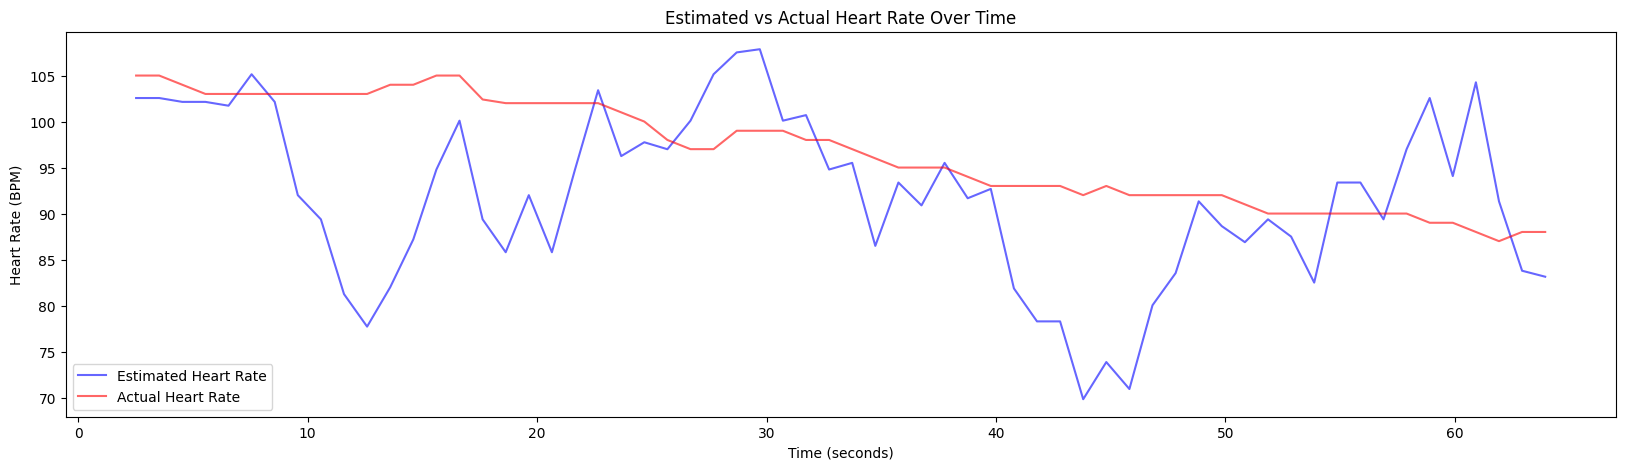

Average Estimated Heart Rate: 91.97
Average Actual Heart Rate: 96.67
MAE: 7.58
RMSE: 10.12
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject47.npz...


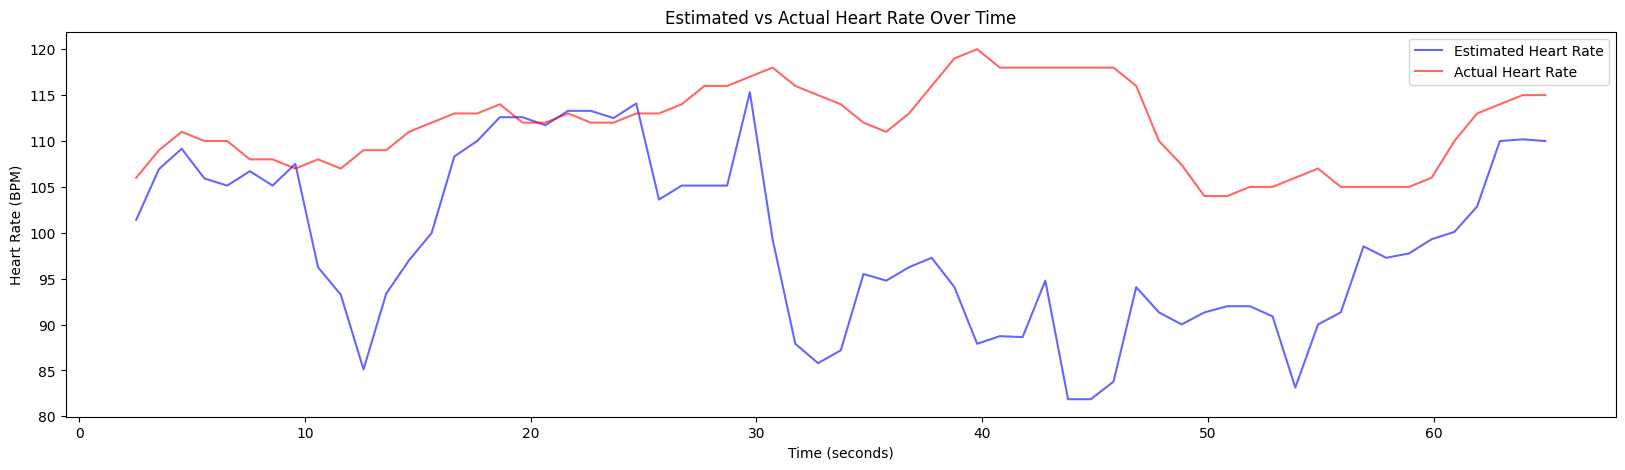

Average Estimated Heart Rate: 98.94
Average Actual Heart Rate: 111.66
MAE: 12.85
RMSE: 16.35
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject48.npz...


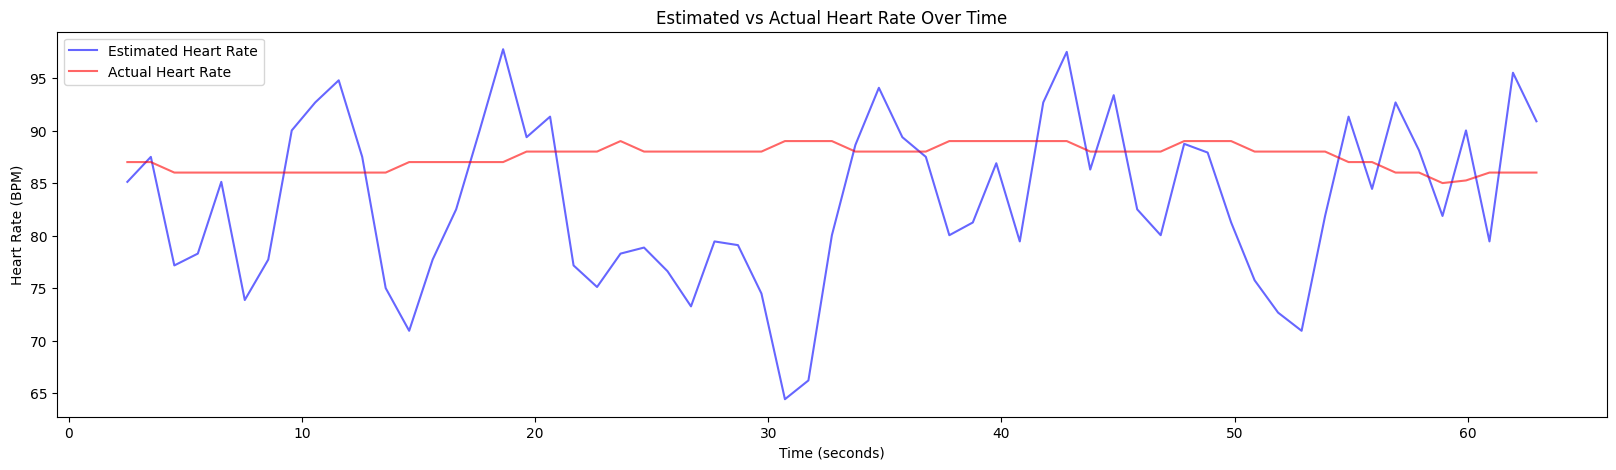

Average Estimated Heart Rate: 83.28
Average Actual Heart Rate: 87.48
MAE: 7.41
RMSE: 9.07
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject49.npz...


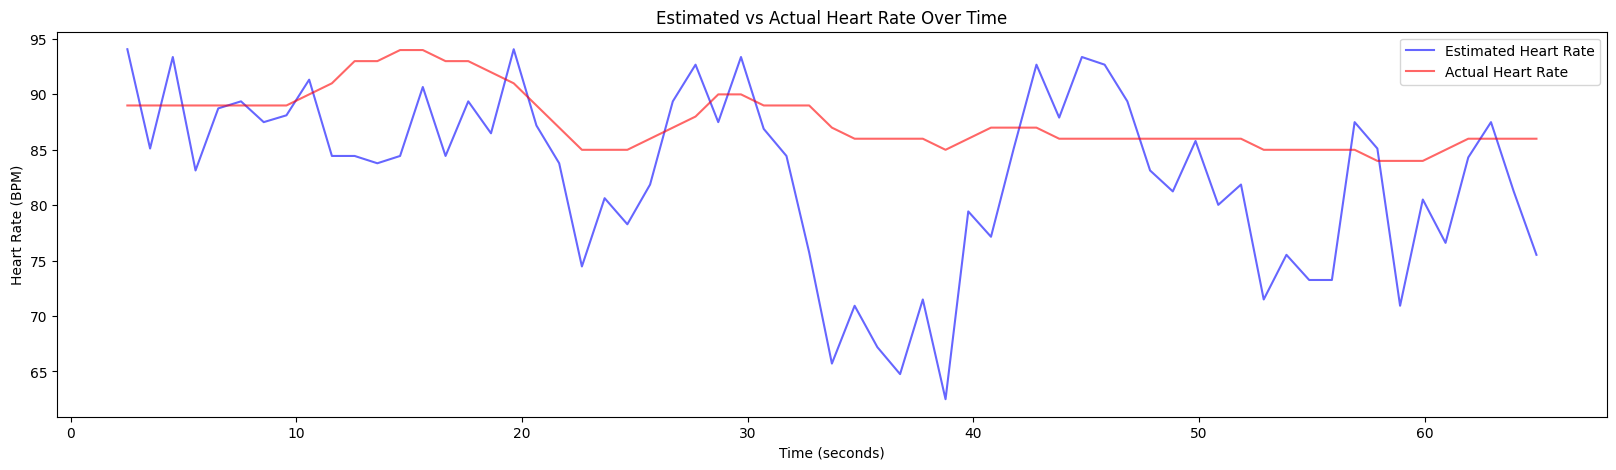

Average Estimated Heart Rate: 82.77
Average Actual Heart Rate: 87.59
MAE: 6.56
RMSE: 8.45
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject5.npz...


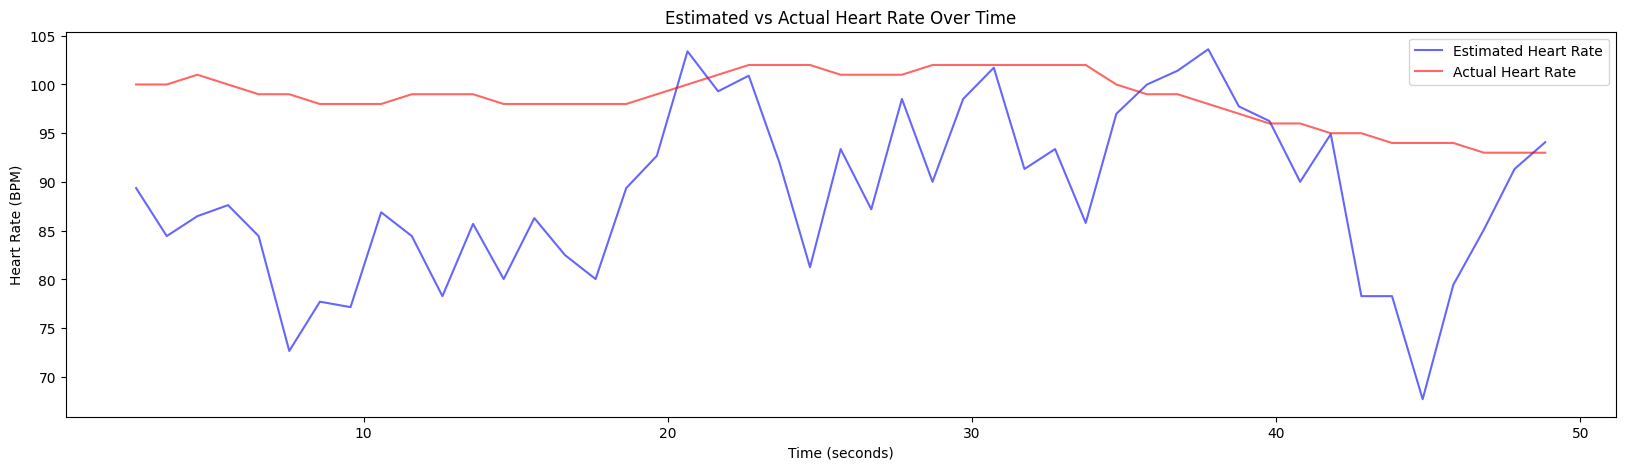

Average Estimated Heart Rate: 88.89
Average Actual Heart Rate: 98.66
MAE: 10.38
RMSE: 12.66
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject8.npz...


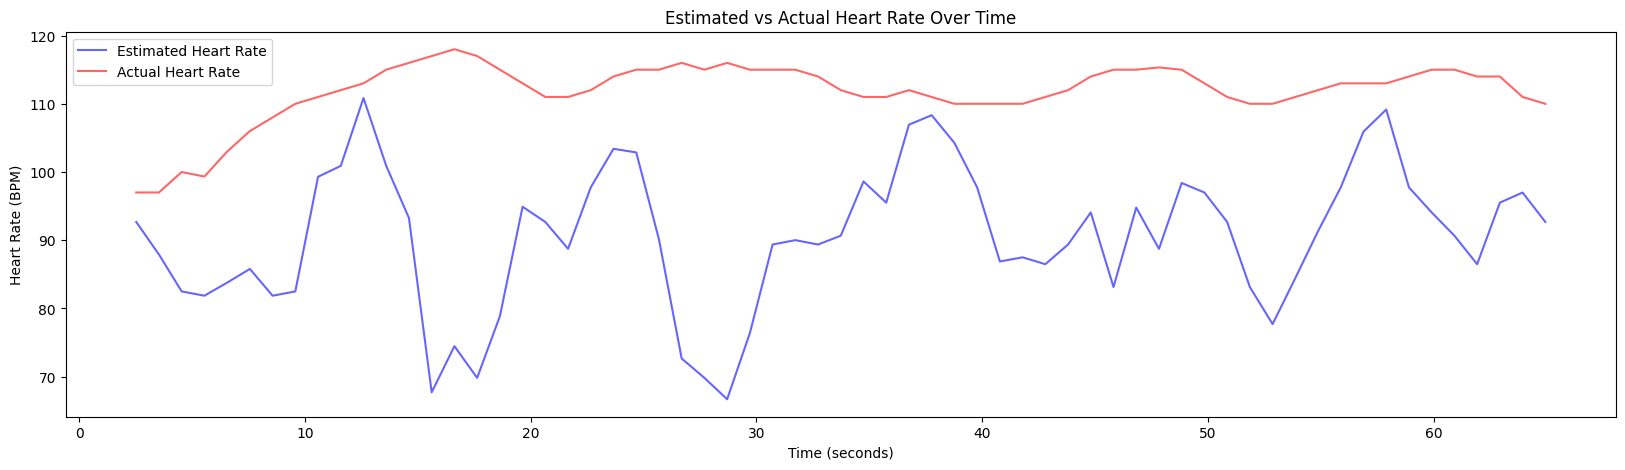

Average Estimated Heart Rate: 90.55
Average Actual Heart Rate: 111.82
MAE: 21.27
RMSE: 24.05
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject9.npz...


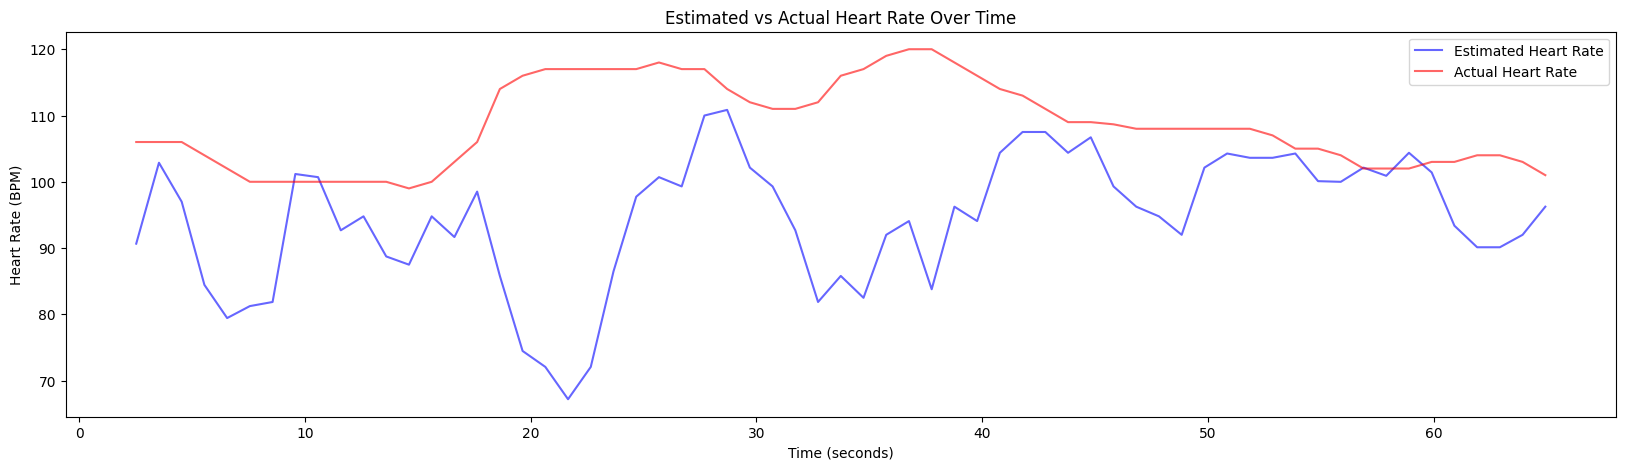

Average Estimated Heart Rate: 94.46
Average Actual Heart Rate: 108.61
MAE: 14.30
RMSE: 18.80
---------------------------------------------------------------------------


In [22]:
directory = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/'

rmse_list, mae_list, subject_list, mean_estimated_hr, mean_actual_hr = process_npz_files(directory)

In [12]:
# 모든 파일의 MAE 출력
print("MAE List:", mae_list)
print("Average MAE across all files:", np.mean(mae_list))
print("---------------------------------------------------------------------------")

MAE List: [18.820585556902017, 22.21763336249726, 33.731313326831696, 12.309417949417126, 20.72886517830388, 10.355590060368248, 26.883603602705154, 4.377338452508273, 7.957344380860503, 29.788736928648706, 33.74376023571891, 14.20708060088332, 19.655737380094717, 15.245779470148003, 14.349037679648681, 15.453764586904423, 8.357260174783438, 15.919875087029977, 11.390438903701567, 2.887106821676411, 13.842117390935027, 27.554438372506283, 30.25417707815332, 14.291220388025017, 30.270214172029615, 18.747082151469016, 15.770449647677339, 5.146461667866322, 20.997350847125404, 3.671050885567151, 13.49679086304681, 9.085133640972563, 13.006820678726745, 6.687473503372908, 15.057950276941972, 7.579932090265293, 12.849393480936845, 7.4066514492887014, 6.559203748301088, 10.383848811819728, 21.272756530308236, 14.296923136443679]
Average MAE across all files: 15.633516917890748
---------------------------------------------------------------------------


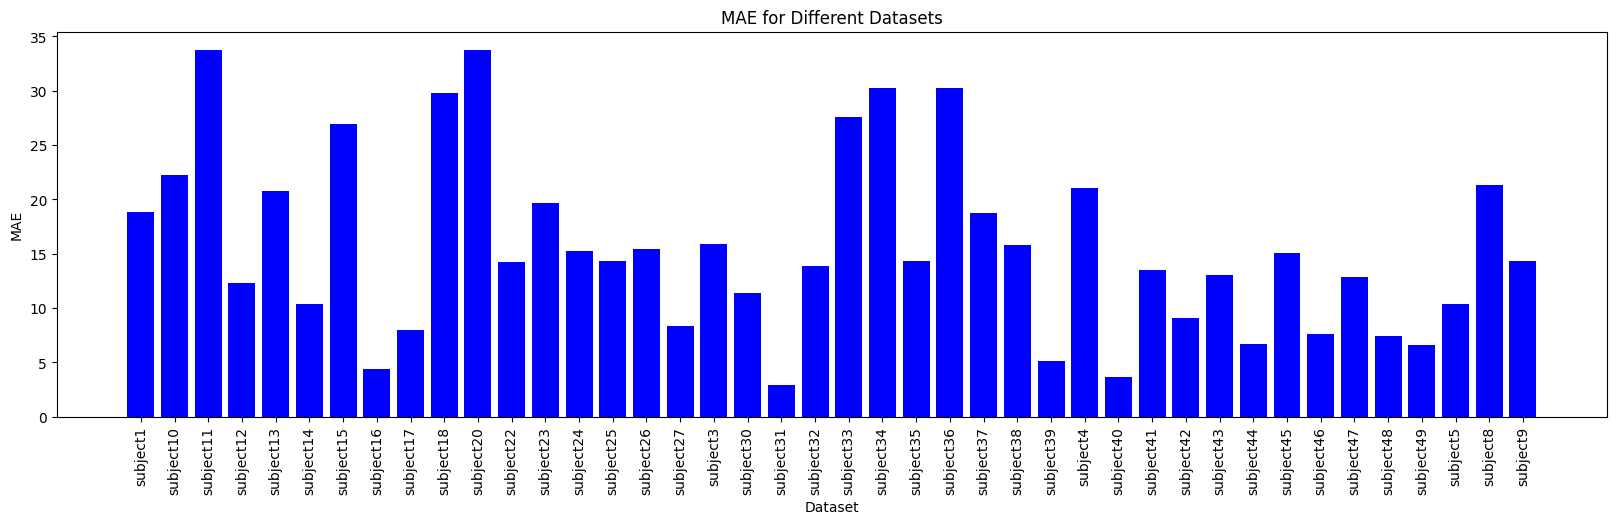

In [26]:
plt.figure(figsize=(20, 5))
plt.bar(subject_list, mae_list, color='blue')
plt.xlabel('Dataset')
plt.ylabel('MAE')
plt.title('MAE for Different Datasets')
plt.xticks(rotation='vertical')
plt.show()

In [14]:
# 모든 파일의 RMSE 출력
print("RMSE List:", rmse_list)
print("Average RMSE across all files:", np.mean(rmse_list))
print("---------------------------------------------------------------------------")

RMSE List: [20.569411511130674, 25.948715000304873, 34.893224260043496, 15.589714043029753, 22.88180168185459, 13.194989086244062, 28.621147098983645, 6.68437348215874, 10.150688594738241, 32.30084195242377, 35.14161794816135, 19.55595589422763, 22.45876673916762, 20.990576683901764, 16.549556318910387, 18.267452897937762, 10.231055080594723, 18.016973741497655, 13.279721395745616, 3.9474268569878297, 16.905345642746436, 29.384490267502233, 31.507144521618635, 18.686510669758242, 32.55000442238988, 22.250789019821454, 18.99014202546178, 6.48369383443562, 22.14761339828709, 5.212619116945887, 16.208214138774597, 11.61882181244075, 14.559055005390995, 8.667669548269641, 18.807760072315766, 10.121522312276904, 16.34784030797317, 9.0713197971177, 8.453663079013728, 12.664057286791708, 24.04779700059872, 18.804408604780516]
Average RMSE across all files: 18.161059336970375
---------------------------------------------------------------------------


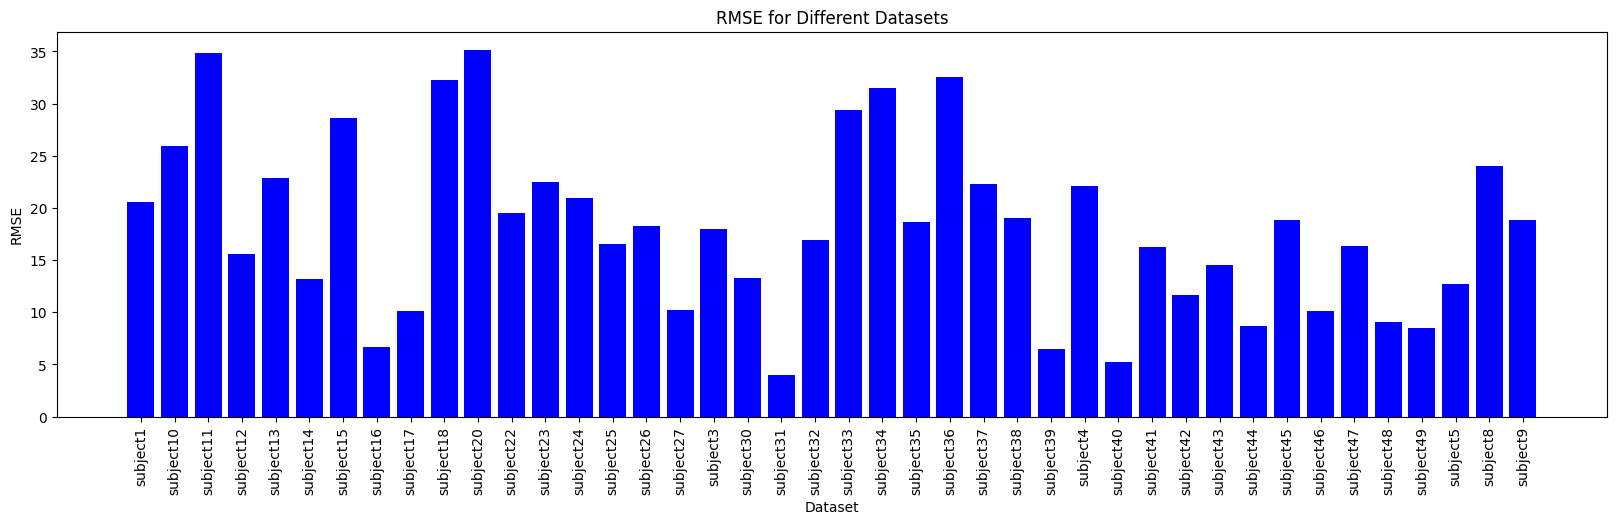

In [15]:
plt.figure(figsize=(20, 5))
plt.bar(subject_list, rmse_list, color='blue')
plt.xlabel('Dataset')
plt.ylabel('RMSE')
plt.title('RMSE for Different Datasets')
plt.xticks(rotation='vertical')
plt.show()

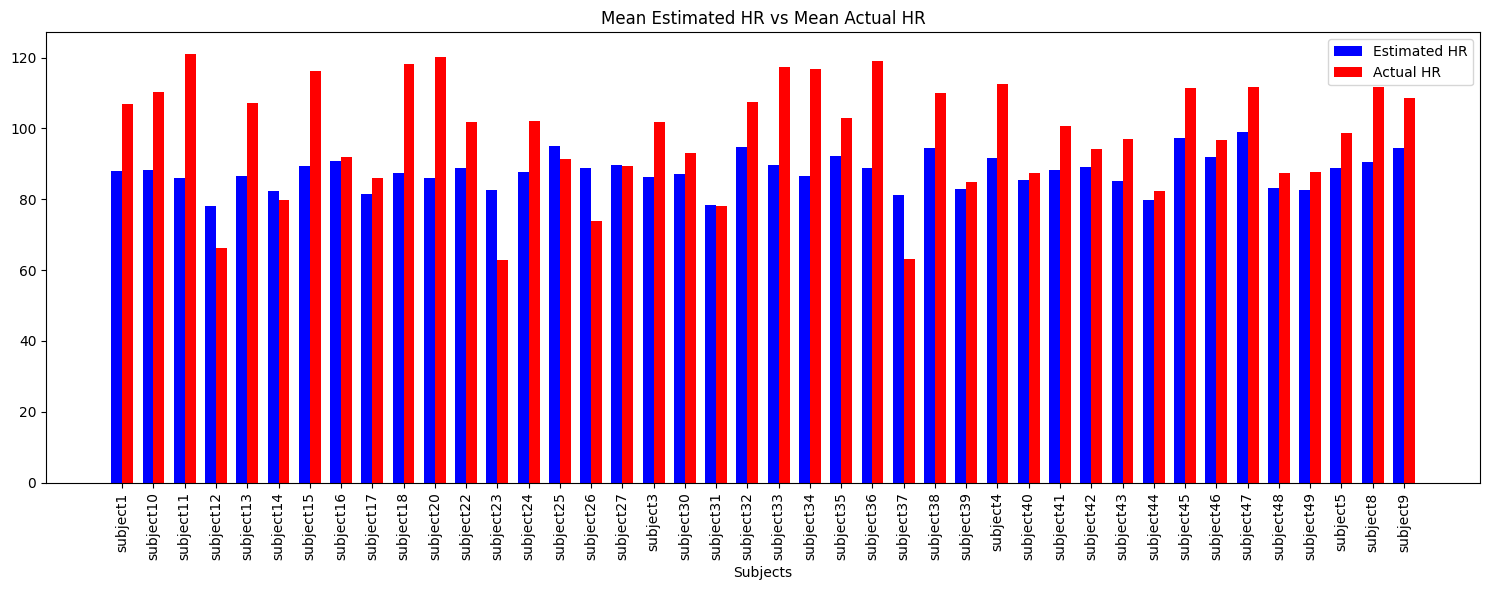

In [23]:
# 막대 그래프를 그립니다.
plt.figure(figsize=(15, 6))  # 그래프 크기 설정
bar_width = 0.35  # 막대 폭 설정

# 각 막대의 위치를 결정하기 위해 x 좌표를 생성합니다.
x = range(len(subject_list))

# 평균 예상 심박수를 나타내는 막대 그래프를 그립니다.
plt.bar(x, mean_estimated_hr, width=bar_width, label='Estimated HR', color='b')

# 평균 실제 심박수를 나타내는 막대 그래프를 그립니다.
plt.bar([i + bar_width for i in x], mean_actual_hr, width=bar_width, label='Actual HR', color='r')

# x 축에 subject_list를 라벨로 설정합니다.
plt.xlabel('Subjects')
plt.xticks([i + bar_width / 2 for i in x], subject_list, rotation=90)  # 라벨을 90도로 회전하여 겹치지 않도록 설정합니다.

# 그래프에 제목과 범례를 추가합니다.
plt.title('Mean Estimated HR vs Mean Actual HR')
plt.legend()

# 그래프를 표시합니다.
plt.tight_layout()  # 레이아웃을 자동으로 조정하여 잘린 텍스트를 방지합니다.
plt.show()

## My video test

In [24]:
def calculate_hr(npz_data, fps=fps, window_size=150, step_size=30):
    """심박수 계산 및 시간 배열 반환"""
    PPG_Signal = extract_green_channel_signal(npz_data)
    bpm_per_frame = []
    times = []

    for start in range(0, len(PPG_Signal) - window_size, step_size):
        end = start + window_size
        segment = PPG_Signal[start:end]
        peaks, _ = find_peaks(segment, distance=fps // 2)

        if len(peaks) > 1:
            ibi = np.diff(peaks) / fps
            bpm = 60 / np.mean(ibi) if len(ibi) > 0 else np.nan
        else:
            bpm = np.nan

        bpm_per_frame.append(bpm)
        times.append((start + end) / 2 / fps)

    return times, bpm_per_frame


def plot_hr(times, bpm_per_frame):
    """심박수 데이터 플롯 및 평균 값 출력"""
    plt.figure(figsize=(20, 5))
    plt.plot(times, bpm_per_frame, label='Estimated Heart Rate', color='blue', alpha=0.6)
    plt.title('Estimated Heart Rate')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.show()

    print(bpm_per_frame)
    print('Average Estimated Heart Rate: ', np.nanmean(bpm_per_frame))


def process_npz_files(directory):
    """디렉토리 내의 모든 NPZ 파일 처리"""
    subject_list = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.npz'):
            file_path = os.path.join(directory, file_name)
            print(f"Processing {file_path}...")
            npz_data = np.load(file_path)
            times, bpm_per_frame = calculate_hr(npz_data)
            plot_hr(times, bpm_per_frame)

Processing /content/drive/MyDrive/everglow/WONSEOKLEE/test/my_test.npz...


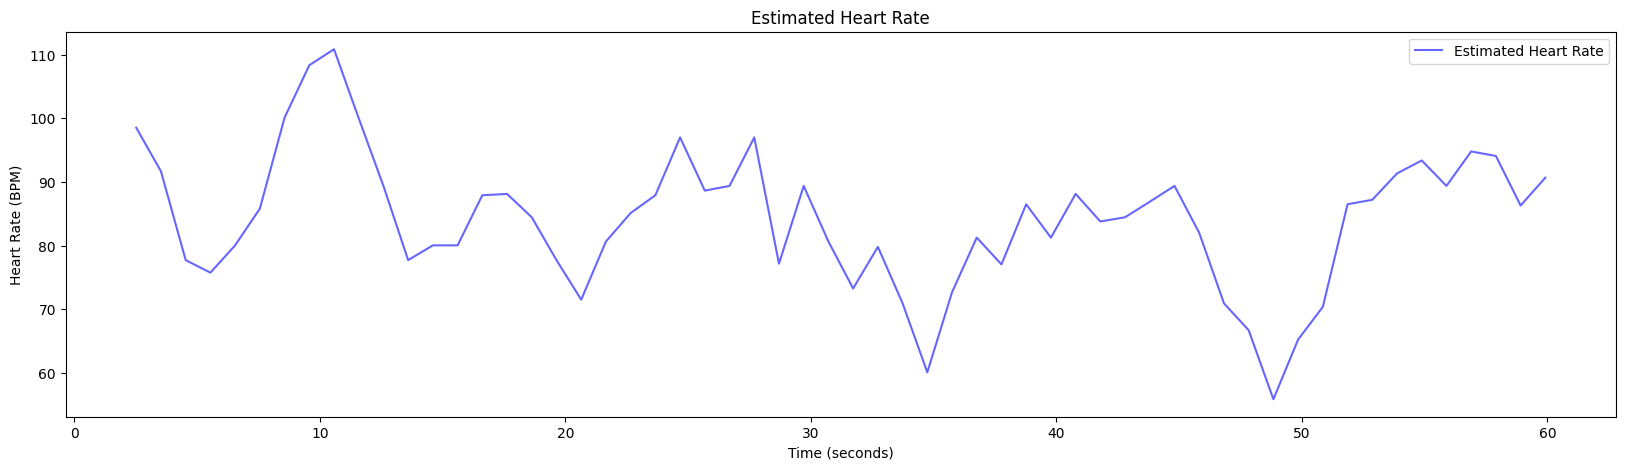

[98.51910236220472, 91.66246153846153, 77.71382608695652, 75.73805084745761, 80.03364179104476, 85.79606399999999, 100.09540799999999, 108.32836363636362, 110.84762790697673, 99.99541258741259, 89.37089999999999, 77.7138260869565, 80.03364179104477, 80.03364179104477, 87.90580327868852, 88.11215492957744, 84.44494488188975, 77.71382608695652, 71.49671999999998, 80.6353984962406, 85.11514285714284, 87.90580327868852, 96.99167441860465, 88.63229752066114, 89.37089999999998, 96.99167441860465, 77.15473381294963, 89.37089999999999, 80.6353984962406, 73.25483606557377, 79.79544642857142, 70.92928571428571, 60.081277310924364, 72.65926829268292, 81.24627272727272, 77.04387931034482, 86.48796774193549, 81.24627272727272, 88.11215492957744, 83.78521874999998, 84.44494488188975, 86.888375, 89.3709, 81.99165137614678, 70.9292857142857, 66.69470149253729, 55.85681249999999, 65.23423357664232, 70.3707874015748, 86.48796774193548, 87.1911219512195, 91.32792700729928, 93.37258208955222, 89.370899999

In [25]:
directory = '/content/drive/MyDrive/everglow/WONSEOKLEE/test/'
process_npz_files(directory)